In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque

In [2]:
# These are universal and do not change
M = 28.9644  # molar mass of air (g/mol)
g = 9.8  # gravitational acceleration (m/s^2)
R = 8.3145  # ideal gas constant (J/K*mol)
elr = 0.0065  # environmental lapse rate (K/m)
ref_t = 293  # reference temperature (K)
ref_p = 101.3  # reference pressur`e (kPa)
L = 2264.76  # latent heat of evaporation (kJ/kg)

In [3]:
# These are assigned (either empirically or arbitrarily)
alpha = 1.26  # alpha (empirically determined)
omega = 2.6  # omega (empirically determined)
pet_0 = 6.66  # baseline PET (mm/day)
Rn_0 = 65.7  # baseline Rn (W m-2); Acquired from NetCDF data
pet_vt = 0.025  # fractional change in PET with temperature
rad_vt = 0.016  # fractional change in radiation with temperature
T0 = 16.2  # baseline temperature (C)
# P0 = 0.479 # baseline precipitation (mm/day)

In [4]:
# Column
# defines the parameters of a column in the basin array. Each column has 4 values:
# ground height, water height, porosity (of the ground), and width
class Column:
    def __init__(self, g_height, porosity, w_height, c_width):
        self.g_height = g_height
        self.porosity = porosity
        self.w_height = w_height
        self.c_width = c_width

    def get_volume(
        self,
    ):  # calculates the volume of water in the column (accounting for the porosity of the ground)
        surf_water = self.w_height - self.g_height
        if surf_water <= 0:
            return self.w_height * self.porosity * self.c_width
        else:
            return self.c_width * (self.g_height * self.porosity + surf_water)

    def get_space(self):  # calculates the empty space below ground
        if (
            self.w_height > self.g_height
        ):  # if there is water above ground, space is negative
            return (self.g_height - self.w_height) * self.c_width
        else:
            return (self.g_height - self.w_height) * self.porosity * self.c_width

    def copy(self):
        return Column(self.g_height, self.porosity, self.w_height, self.c_width)

In [5]:
# Two Dimensional Basin
# Creates a two-dimensional basin from the given parameters
# TODO: Change this:
# Assigns a ground level and water level for each column, based on the initial slope of each
# The lake is filled from the left of the basin to the right so that the al/ab is correct
# After the lake is filled, the groundwater is determined by the g_slope
def col_two_d_basin(width, porosity, g_slope, w_slope, al_ab, cell_w):
    basin = np.empty(width, dtype=Column)

    max_i = math.ceil(width * al_ab)  # x-coordinate of column adjacent to lake

    lake_level = (
        g_slope * max_i * cell_w
    )  # elevation of lake (equal to height of ground in column adjacent)

    for i in range(width):
        if (
            i <= max_i
        ):  # all columns in lake plus one column adjacent (which is fully saturated)
            basin[i] = Column(g_slope * i * cell_w, porosity, lake_level, cell_w)
        else:
            water_above_lake = (
                w_slope * (i - max_i) * cell_w
            )  # increase in water table above lake level
            basin[i] = Column(
                g_slope * i * cell_w, porosity, lake_level + water_above_lake, cell_w
            )

    return basin

In [6]:
def copy_basin(basin):
    new_basin = np.empty(len(basin), dtype=Column)
    for i in range(len(basin)):
        new_basin[i] = basin[i].copy()
    return new_basin

In [48]:
# Darcy
# Given the height of the left cell, the height of the right cell, the horizontal distance between the cells, and the permeability of the cells, returns the flow rate per hour
# some constants can be adjusted such as the conductivity (calculated given perm or from a separate source)
# time is number of days


def darcy(right, left, hor_dist, cond, time):

    # hydraulic conductivity:
    # permeability * density of water * gravitational acceleration * (viscosity)-1
    # m2 * kg m-3 * m s-2 * Pa-1 s-1 = kg s-3 Pa-1 = m s-1
    # k_math = (perm * 998 * 9.8) / 1305900

    # default hydraulic conductivity from textbook = 10e-7 m s-1
    if right == left:
        return 0

    h_dif = right - left  # vertical distance

    # adjust rate of movement based on length of time step
    k = 86400 * cond * time

    q = (h_dif * k) / hor_dist

    # if the change is greater than the height difference, default to evening the heights
    if abs(q) > abs(h_dif / 2):
        q = h_dif / 2

    return q

In [8]:
# Calculate evaporation
# calculates the evaporation from 1 m2 of lake
# temp is in C
# z is elevation (m)
# time is number of days
# Rn_0, rad_vt, T0, and alpha change the sensitivity of evaporation


def calc_evap(
    temp, z, time, Rn_0=Rn_0, rad_vt=rad_vt, T0=T0, alpha=alpha, ignore=False
):
    """evap in m from m2 of lake"""
    if ignore:
        return 0
    # atmospheric pressure (kPa)
    p = ref_p * ((ref_t - elr * z) / ref_t) ** 5.26

    # slope of the saturation vapor pressure curve (kPa K-1)
    slope_sat = (
        4098
        * (0.6108 * math.exp((17.27 * temp) / (temp + 237.3)))
        / ((237.3 + temp) ** 2)
    )

    # psychrometric constant (kPa K-1)
    y = 0.665 * 10 ** (-3) * p

    # net downward radiation (W m-2)
    rad = Rn_0 + Rn_0 * rad_vt * (temp - T0)

    # evaporation of lake (0.0864 m day-1)
    e_lake = 0.0864 * time * (alpha * (slope_sat / (slope_sat + y)) * rad) / L
    return e_lake

In [9]:
# Adjust Column
# Given a volume change for each column, adjusts each
# returns any overflow above ground level
def col_adj_col(col, vol_change):
    to_return = 0
    space = col.get_space()

    if (
        space <= 0
    ):  # if column has water above ground level, remove it and add to vol_change
        vol_change -= space  # space can be negative
        col.w_height = col.g_height
        space = 0

    if vol_change > 0:  # adding water to column
        if vol_change < space:
            col.w_height = col.w_height + (vol_change / col.porosity / col.c_width)
            to_return = 0
        else:
            col.w_height = col.g_height
            to_return = float(vol_change - space)
    elif vol_change <= 0:  # removing water from column
        col.w_height += vol_change / col.porosity / col.c_width
        to_return = 0

    return to_return

In [10]:
# Fill Lake
# Fills the 'lake' with all excess volume so that the water level of the lake is even


def col_fill_lake(ar, volume):
    basin_width = ar.shape[0]

    vol_left = volume
    i = 0
    lake_width = 0
    lake_height = 0
    while vol_left > 10e-7:
        if i >= basin_width - 1:
            raise Exception("Basin overflows")

        wid_cell = ar[i].c_width

        back_fill = min(vol_left, ar[i].get_space())
        if back_fill > 0:
            porosity = ar[i].porosity
            ar[i].w_height += back_fill / wid_cell / porosity
            vol_left -= back_fill
            # print('eeeeee')
        else:
            lake_width += wid_cell
            h_diff = ar[i + 1].g_height - ar[i].g_height
            vol_dist = vol_left / lake_width
            # if(h_diff > vol_dist):
            # print("it's bigger")
            to_add = min((ar[i + 1].g_height - ar[i].g_height), vol_left / lake_width)
            lake_height += to_add
            vol_left -= to_add * lake_width
            # if(h_diff > vol_dist):
            # print(vol_left)
            i += 1

    for j in range(i):
        ar[j].w_height = lake_height

    # print(col_count_water(ar))

    return ar

In [11]:
# Move water
# moves water based on Darcy's law and removes water from the lake based on the evaporative conditions
# ar: the basin array
# dim: the dimensions of each cell
# evap: the volume of water evaporated from m2 open water
def col_move_water(ar, evap, cond, time, ignore_evap=False):
    width = ar.shape[0]

    vol_change = np.zeros(width)  # records the change from each column

    # evaporate water from lake
    if not ignore_evap:
        for i in range(width):
            if ar[i].w_height > ar[i].g_height:
                vol_change[i] -= (
                    evap * ar[i].c_width
                )  # records change for each column in vol_change

    prevap = np.sum(vol_change)

    # calculates vol_change for each column, starting at the right(top of basin)
    for i in range(width - 1):
        pos = width - i - 1

        water = ar[pos].w_height
        adj_ground = ar[pos - 1].g_height
        adj_water = ar[pos - 1].w_height
        w_depth = adj_ground - water
        # cond = max(cond * (20 - w_depth) / 10, cond)
        # if (ar[i].w_height - water < ) :
        #     # cond = (cond + 10e-1) / 2 # I don't know if this is reasonable
        #     cond = cond * 2

        if not isinstance(ar[pos].c_width, int):
            print("hi")
        # calculate flow from current cell to the adjacent cell based on Darcy's law
        f_rate = darcy(water, adj_water, ar[pos].c_width, cond=cond, time=time)

        # adjust vol_change for both cells
        vol_change[pos] -= f_rate * ar[pos].c_width
        vol_change[pos - 1] += f_rate * ar[pos].c_width
        # if np.isnan(vol_change[pos]):
        #     print('yooo')

    vol_change[np.isnan(vol_change)] = 0
    aevap = np.sum(vol_change)
    # print(aevap)
    # print(col_count_water(ar) + prevap, col_count_water(ar) + aevap)
    carry_over = 0  # volume of overflow (water above ground), from previous column
    for i in range(width):
        pos = width - i - 1

        # adjusts column based on volume change, saturating from the bottom up. Calculates any overflow.
        # overflow is added to the next available column
        carry_over = col_adj_col(ar[pos], vol_change[pos] + carry_over)
    # print(col_count_water(ar) + carry_over)
    ar = col_fill_lake(ar, carry_over)

In [12]:
# Calculate krun
# temp C
# precip mm/day
def calc_krun(
    temp, precip, pet_0=pet_0, pet_vt=pet_vt, omega=omega, T0=T0, ignore=False
):
    if precip == 0:  # avoids dividing by zero
        return 0

    if ignore:  # for testing without PET effects
        return 1

    # timed_pet_0 = pet_0 * time # PET is initially in mm day-1, time is number of days
    # don't need bc as long as precip is in days

    # potential evapotranspiration (mm)
    pet = pet_0 + pet_0 * pet_vt * (temp - T0)

    # fraction of precipitation converted into runoff
    krun = -1 * ((pet / precip) - (1 + (pet / precip) ** omega) ** (1 / omega))

    return krun

In [13]:
# Add water
# Adds water to each column of the basin.
# Adds from the right to left within the basin
# If there is overflow from any column (water above ground), it is added to the next column
# All water above ground left over is then redistributed so that the lake is flat
# precip should be in mm
def col_add_water(precip, temp, ar, time, ignore_evap=False):
    width = ar.shape[0]

    free_vol = 0  # carry over from the adjacent column

    for i in range(width):
        pos = width - i - 1
        krun = calc_krun(temp[pos], precip[pos], ignore=ignore_evap)
        rain = (
            precip[pos] * ar[pos].c_width * time / 1000
        )  # convert precip from mm to m
        land_add = krun * rain + free_vol
        space = ar[pos].get_space()

        if space < 0:  # water is above ground level
            ar[pos].w_height = ar[pos].g_height
            free_vol += (
                rain - space
            )  # adds precip and water above ground (space will be negative in this case)
        elif land_add < space:  # water is below ground with enough space
            ar[pos].w_height += land_add / ar[pos].porosity / ar[pos].c_width
            free_vol = 0
        else:  # water is below ground without enough space
            ar[pos].w_height = ar[pos].g_height
            free_vol = land_add - space
    # print(col_count_water(ar) + free_vol)
    ar = col_fill_lake(ar, free_vol)

    return ar, free_vol

In [14]:
# View system
# Shows a graphical representation of the basin
# plots the ground level and water table
def col_view_sys(ar, lims=[]):

    ground_height = np.array([cell.g_height for cell in ar])
    water_height = np.array([cell.w_height for cell in ar])
    widths = np.array([cell.c_width for cell in ar])

    x_values = np.cumsum(widths)

    plt.plot(x_values, ground_height, color="green")
    plt.plot(x_values, water_height, color="blue")

    if len(lims) == 4:
        plt.xlim(lims[0], lims[1])
        plt.ylim(lims[2], lims[3])

    plt.show()

In [15]:
# Count water
# calculates the total volume of water in the system
def col_count_water(ar):
    return np.sum([cell.get_volume() for cell in ar])

In [16]:
# Calculate the lake area
# in columns
def col_calc_al(ar):
    width = ar.shape[0]
    for i in range(width):
        if (
            ar[i].w_height <= ar[i].g_height
        ):  # the first instance of the water table being at or below the ground level
            return i

In [ ]:
# Run iteration
def run_iter(basin, precip, temp, width, elev, cond, t_step):
    """returns list with al_ab, volume, w_table, precip, temp, evap"""
    col_add_water(precip, temp, basin, t_step)
    evap = calc_evap(temp[0], elev, t_step)
    col_move_water(basin, evap, cond, t_step)

    al_ab = col_calc_al(basin) / width
    volume = col_count_water(basin)
    w_table = basin[width - 1].w_height
    return [al_ab, volume, w_table, precip[0], temp[0], evap]

In [18]:
# Run simulation
# runs a simulation with the given parameters
# climate is a 2-d array where the first column is precipitation (mm) and the second is temp (C). Each row is one time step
def run_sim(
    width,
    porosity,
    ground_slope,
    water_slope,
    al_ab,
    climate,
    elev,
    col_width,
    cond,
    t_step,
    iter,
    output_f,
    lims=[],
):
    basin_ar = col_two_d_basin(
        width, porosity, ground_slope, water_slope, al_ab, col_width
    )

    # creates table for results
    columns = [
        "iteration",
        "al_ab",
        "water_volume",
        "water_table",
        "precip",
        "temp",
        "evap",
    ]
    results = pd.DataFrame(columns=columns)

    # adds initial setup to results as the first row
    row = [
        0,
        al_ab,
        col_count_water(basin_ar),
        basin_ar[width - 1].w_height,
        "",
        "",
        "",
    ]
    results.loc[len(results)] = row

    for i in range(iter):
        # converts climate into array for each column of basin
        precip = climate[i, 0]
        p_array = np.full(width, precip)
        temp = climate[i, 1]
        t_array = np.full(width, temp)

        # lines for testing
        # pre_al = col_calc_al(basin_ar)
        # pp_vol = col_count_water(basin_ar, col_width)

        # col_add_water(p_array, t_array, basin_ar, ground_slope, time=t_step)

        # lines for testing
        # e_added = col_width * t_step * (calc_krun(temp, precip) * (width - pre_al) + pre_al) * precip / 1000
        # al = col_calc_al(basin_ar)
        # p_vol = col_count_water(basin_ar, col_width)
        # a_added = p_vol - pp_vol

        # evap = calc_evap(t_array[0], elev, Rn_0=Rn_0, time=t_step)
        # col_move_water(basin_ar, col_width, ground_slope, evap, cond, time=t_step)

        # lines for testing
        # a_vol = col_count_water(basin_ar, col_width)
        # expected_loss = col_width * evap * al
        # actual_loss = p_vol - a_vol

        row = run_iter(
            basin_ar,
            p_array,
            t_array,
            width,
            elev,
            cond,
            t_step,
        )
        row.insert(0, i + 1)

        # row = [i+1, col_calc_al(basin_ar)/width, col_count_water(basin_ar, col_width), basin_ar[width - 1].w_height, precip, temp, evap, e_added, a_added, al, expected_loss, actual_loss, col_width]
        results.loc[len(results)] = row

        if math.fmod(i, output_f) == 0:
            print("iteration done:", i)
            col_view_sys(basin_ar, lims)

    col_view_sys(basin_ar, lims)

    return results

In [19]:
def steady_al(p, t, width, elev, time):
    """returns the lake area with the smallest volume change"""
    vol_change = np.zeros(width + 1)
    overflows = False
    for i in range(width + 1):

        lake_add = time * p * i / 1000
        land_add = time * p * calc_krun(t, p) * (width - i) / 1000
        lake_remove = i * calc_evap(t, elev, time)
        diff = lake_add + land_add - lake_remove
        vol_change[i] = abs(diff)
        if i == width and diff > 0:
            overflows = True

    if overflows:
        return -1
    else:
        # return index of smallest value in vol_change
        return np.argmin(vol_change)

In [20]:
def calc_overturn(al, width, p, t, elev):
    """returns the rate of water overturn (m/day)"""
    lake_add = p * al / 1000
    land_add = p * calc_krun(t, p) * (width - al) / 1000
    total_add = lake_add + land_add
    lake_remove = al * calc_evap(t, elev, 1)
    return (total_add + lake_remove) / width * 2

In [21]:
# Steady state
def steady_state(
    climate,
    elev,
    cond,
    t_step,
    precision,
    view=False,
    basin=None,
    width=None,
    porosity=None,
    ground_slope=None,
    water_slope=None,
    al_ab=None,
    col_width=None,
):
    if basin is None:
        basin_ar = col_two_d_basin(
            width, porosity, ground_slope, water_slope, al_ab, col_width
        )
    else:
        basin_ar = basin

    # creates table for results
    # columns = ['iteration', 'al_ab', 'water_volume', 'water_table', 'precip', 'temp', 'evap']
    # results = pd.DataFrame(columns=columns)

    # record = pd.DataFrame(columns=['iteration', 'al', 'volume', 'water_table'])
    # change_cols = ['al_ab', 'water_volume', 'water_table']
    # change = pd.DataFrame(columns=change_cols)

    shape = climate.shape[0]

    prev_iter = []
    change_row = []
    # prev_change = []
    # al_time = 0
    # al_times = []
    # al_record = deque([-1] * 200, maxlen=200)
    steady = False
    i = 0
    while not steady:
        width = basin_ar.shape[0]
        tot_width = width * basin_ar[0].c_width
        clim_i = int(math.fmod(i, shape))
        precip = np.full(width, climate[clim_i, 0])
        temp = np.full(width, climate[clim_i, 1])
        row = run_iter(basin_ar, precip, temp, width, elev, cond, t_step)
        # row.insert(0, i+1)
        # results.loc[len(results)] = row

        # if (i % precision) == (precision - 1) and i > 0:
        if (i % precision) == (precision - 1) and i > 500:
            al_change = row[0] - prev_iter[0]
            vol_change = (row[1] - prev_iter[1]) / tot_width
            table_change = row[2] - prev_iter[2]
            one = False
            two = False
            three = False
            # print(f'iteration {i} iteration {i} iteration {i}')
            # print(f'al: {row[0]} d_al: {al_change} d_vol: {vol_change} d_table: {table_change}')
            if al_change == 0:
                # print('yes 1')
                one = True
            # if abs(vol_change) < 10e-3:
            if abs(vol_change) < 10e-4:
                # print('yes 2')
                two = True
            if abs(table_change) < 10e-5:
                # print('yes 3')
                three = True
            if one and two and three:
                steady = True
                change_row = [al_change, vol_change, table_change]
        if i % 20000 == 0 and i > 0:
            print(f"iteration {i}")
            print(
                f"al: {row[0]} d_al: {al_change} d_vol: {vol_change} d_table: {table_change}"
            )
        if view and (i % 20000) == 0:
            col_view_sys(basin_ar)
        if (i % precision) == 0:
            prev_iter = row

        i += 1

        # change_row = []
        # if i >= 1:
        #     for j in range(len(change_cols)):
        #         change_row.append(row[j] - prev_iter[j])
        #     if (row[0] == prev_iter[0]):
        #         al_time += 1
        #     else:
        #         al_record.append(prev_iter[0])
        #         al_times.append(al_time)
        #         al_time = 0

        #     if ((al_time > 500) or (row[0] == al_record[197]) or (row[0] == al_record[196])):
        #         if(abs(change_row[2]) < 0.00001):
        #             steady = True

        # size = len(al_record)
        # if size > 4:
        #     sum_al = 0
        #     for i in range(4):
        #         sum_al += al_record[len(al_record) - 1 - i]
        #     if sum_al == 0:
        #         steady = True

        # if (change_row[0] == 0 and abs(change_row[1]) <= 1 and abs(change_row[2]) <= 0.1):
        #     steady = True
        # elif (i >=2):
        #     if (change_row[1] * prev_change[1]) < 0:
        #         steady = True

        # if (i % 10000) == 0:
        #     print("iteration done:", i)
        #     col_view_sys(basin_ar)
        # if (i % 1000) == 500:
        #     print(al_time > 500)
        #     print(abs(change_row[2]) < 0.001)
        #     print(steady)
        #     print(change_row)
        #     print(row)

        # prev_iter = row
        # prev_change = change_row

    col_view_sys(basin_ar)
    return i, row, change_row

In [22]:
def steady_state_al(
    p,
    t,
    elev,
    cond,
    t_step,
    precision,
    pct_al,
    view=False,
    basin=None,
    width=None,
    porosity=None,
    ground_slope=None,
    water_slope=None,
    al_ab=None,
    col_width=None,
):
    if basin is None:
        basin_ar = col_two_d_basin(
            width, porosity, ground_slope, water_slope, al_ab, col_width
        )
    else:
        basin_ar = basin

    begin_al = col_calc_al(basin_ar)

    final_al = steady_al(p, t, basin_ar.shape[0], elev, t_step)

    # find middle al (round to nearest whole number)
    mid_al = (final_al - begin_al) * pct_al + begin_al
    # round to nearest whole number
    mid_al = round(mid_al)

    if mid_al == begin_al:
        return 0, begin_al, final_al, mid_al

    print(begin_al, final_al, mid_al)

    steady = False
    i = 0
    while not steady:
        width = basin_ar.shape[0]
        tot_width = width * basin_ar[0].c_width
        precip = np.full(width, p)
        temp = np.full(width, t)
        run_iter(basin_ar, precip, temp, width, elev, cond, t_step)

        if (i % precision) == 0:
            if col_calc_al(basin_ar) == mid_al:
                steady = True
        if i % 5000 == 0:
            print(f"iteration {i}")
            print(col_calc_al(basin_ar))
        if view and (i % 20000) == 0:
            col_view_sys(basin_ar)

        i += 1

    # col_view_sys(basin_ar)
    return i, begin_al, final_al, mid_al

Testing

In [23]:
# Testing method that returns 1 if result is expected, zero otherwise
def test(actual, expected, accepted_error=0):
    if abs(actual - expected) <= accepted_error:
        return 1
    else:
        return 0

In [24]:
# tests that the initialization of the basin and the add and move functions work properly (not considering evaporation)
# tests across a variety of conditions
def test_setup():
    width = 13
    porosity = 0.3
    ground_slope = 0.4
    water_table_slope = 0
    al_ab = 0
    rain_amt = 10
    temp_amt = 0
    ignore_evap = True
    iter = 2
    cell_width = 3

    count_test = 0
    count_correct = 0

    for i in range(iter):
        width += 7
        for i in range(iter):
            porosity += 0.05
            for i in range(iter):
                ground_slope += 0.05
                for i in range(iter):
                    water_table_slope += 0.025
                    for i in range(iter):
                        al_ab += 0.025
                        big_basin = col_two_d_basin(
                            width,
                            porosity,
                            ground_slope,
                            water_table_slope,
                            al_ab,
                            cell_width,
                        )

                        calc_area = col_calc_al(big_basin)
                        expected_area = math.ceil(al_ab * width)
                        count_correct += test(calc_area, expected_area)

                        calc_lake_elev = big_basin[0].w_height
                        expected_elev = expected_area * ground_slope * cell_width
                        count_correct += test(calc_lake_elev, expected_elev)

                        calc_water_table = big_basin[width - 1].w_height
                        expected_water_table = (
                            expected_elev
                            + (width - expected_area - 1)
                            * water_table_slope
                            * cell_width
                        )
                        count_correct += test(calc_water_table, expected_water_table)

                        begin_volume = col_count_water(big_basin)
                        rain = np.full(width, rain_amt)
                        temp = np.full(width, temp_amt)
                        col_add_water(rain, temp, big_basin, 1, ignore_evap=True)
                        calc_vol = col_count_water(big_basin)
                        expected_vol = begin_volume + (
                            cell_width * rain_amt * width / 1000
                        )
                        count_correct += test(calc_vol, expected_vol, 0.0001)

                        col_move_water(big_basin, 0, 10e-7, 1, ignore_evap)
                        calc_vol = col_count_water(big_basin)
                        count_correct += test(calc_vol, expected_vol, 0.0001)
                        count_test += 5
                    al_ab = 0
                water_table_slope = 0
            ground_slope = 0.4
        porosity = 0.1

    return (count_test, count_correct)


test_setup()

(160, 160)

In [25]:
# tests the method for applying Darcy's Law
def test_darcy():
    count_test = 0
    count_correct = 0
    time = 1
    left = 0
    right = 10
    hor_dist = 1
    conductivity = 10e-7

    for _ in range(10):
        result = darcy(right, left, hor_dist, conductivity, time)
        expected = 86400 * conductivity * (right - left) / hor_dist
        count_correct += test(result, expected)
        count_test += 1
        left += 1
        right += 1
        hor_dist += 1

    # results should follow (cond * number of seconds * (right - left)/hor_dist)
    # unless flow is greater than half of the difference in height (then it should be equal to half the distance)

    right_h = [10, 5, 0, 9, 4, -3, 12, -10, 50, 50]
    left_h = [0, 5, 10, 3, 9, 2, 2, 0, 25, 25]
    width = [1, 1, 1, 6, 1, 1, 1, 2, 5, 5]
    cond = [10e-7, 10e-7, 10e-7, 10e-7, 10e-6, 10e-8, 10e-9, 10e-7, 10e-4, 10e-3]
    time = [1 / 24, 1 / 24, 1 / 24, 1, 1 / 24, 1 / 24, 30, 30, 30, 1]
    expected = [0.036, 0, -0.036, 0.0864, -0.18, -0.0018, 0.2592, -5, 12.5, 12.5]

    for i in range(len(left_h)):
        result = darcy(right_h[i], left_h[i], width[i], cond=cond[i], time=time[i])
        count_correct += test(result, expected[i], accepted_error=10e-10)
        count_test += 1

    return (count_test, count_correct)


test_darcy()

(20, 20)

In [26]:
# Tests the method for calculating krun given precip and temp
def test_krun():
    # this depends on the determinations of PET_0, PET_vt, omega, and T0
    # these tests assume 5, 0.025, 2.6, and 11 respectively
    count_test = 0
    count_correct = 0

    precip = [1, 4, 0, 100, 5, 10]
    temp = [10, 15, 11, 5, -5, 0]
    expected = [0.0303464, 0.2057201, 0, 0.9576044, 0.49461487, 0.66441087]

    for i, item in enumerate(precip):
        count_test += 1
        actual = calc_krun(temp[i], item, pet_0=5, pet_vt=0.025, omega=2.6, T0=11)
        count_correct += test(actual, expected[i], 10e-7)

    return count_test, count_correct


test_krun()

(6, 6)

In [27]:
# Tests the method that calculates lake evaporation given temperature and elevation
def test_lake_evap():
    count_test = 0
    count_correct = 0

    temp = [-5, 0, 0, 5, 10, 15, 4]
    elevation = [0, 0, 1000, 2000, 500, 1000, 4000]
    expected = [
        0.00005768907297,
        0.000078729,
        0.000084388,
        0.000116099,
        0.0001334605,
        0.0001654862,
        0.0001239482,
    ]

    for i, item in enumerate(temp):
        count_test += 1
        actual = calc_evap(item, elevation[i], 1, 5, 0.016, 11)
        count_correct += test(actual, expected[i], 10e-7)

    return count_test, count_correct


test_lake_evap()

(7, 7)

In [28]:
# Tests the system to ensure that the amount of volume is correct given the amount of rain added and the temperature
# These tests rely on the methods calc_krun and calc_evap being correct
def test_sys():
    count_correct = 0
    count_test = 0
    width = 10000
    porosity = 0.4
    g_slope = 0.21
    w_slope = 0.2
    al_ab = 0.4
    z = 1000
    cond = 15e-7
    col_w = 10
    time = 10
    rain_amt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 20, 30, 200, 2, 0, 0, 0, 20]
    temp_amt = [-3, -1, 0, 2, 4, 6, 8, 10, 12, 14, 18, 10, 8, 4, 12, 50, 50, 50, 10]

    basin = col_two_d_basin(width, porosity, g_slope, w_slope, al_ab, col_w)

    for i in range(len(rain_amt)):
        begin_volume = col_count_water(basin)
        begin_al = col_calc_al(basin)

        rain = np.full(width, rain_amt[i])
        temp = np.full(width, temp_amt[i])
        land_precip = rain_amt[i] * calc_krun(temp_amt[i], rain_amt[i]) / 1000
        col_add_water(rain, temp, basin, time=time)

        actual_vol = col_count_water(basin)
        expected_vol = (
            time
            * col_w
            * (((begin_al * rain_amt[i]) / 1000) + (land_precip * (width - begin_al)))
        )
        count_correct += test(
            actual_vol - begin_volume, expected_vol, accepted_error=10e-5
        )
        # print(expected_vol + begin_volume - actual_vol)
        count_test += 1

        new_al = col_calc_al(basin)
        lake_evap = calc_evap(temp_amt[i], z, 1, Rn_0, rad_vt, T0, alpha)
        col_move_water(basin, lake_evap, cond, time=time)
        expected_loss = col_w * lake_evap * new_al
        actual_loss = actual_vol - col_count_water(basin)
        # print(col_calc_al(basin), new_al, expected_loss, actual_loss)
        count_correct += test(actual_loss, expected_loss, accepted_error=10e-5)
        count_test += 1

    return count_test, count_correct


test_sys()

(38, 38)

running with width50
iteration done: 0


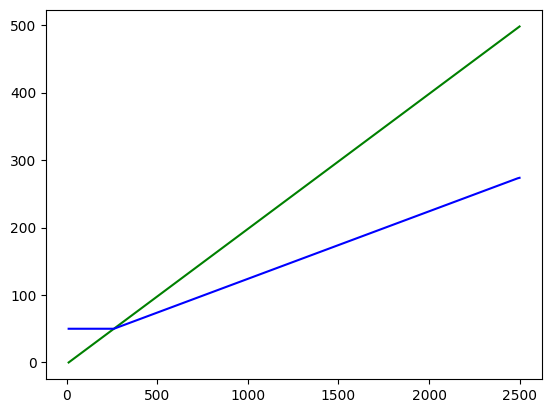

KeyboardInterrupt: 

In [29]:
iters = 60000
climate = np.zeros((iters, 2))
climate[:, 0] = 0.5
climate[:, 1] = 16
for i in range(1):
    width = i * 50 + 250
    print("running with width" + str(i * 50 + 50))
    df = run_sim(
        width,
        0.3,
        0.2,
        0.1,
        0.1,
        climate,
        elev=1000,
        col_width=10,
        cond=10e-7,
        t_step=10,
        iter=iters,
        output_f=10000,
    )

In [ ]:
iters = 100000
climate = np.zeros((iters, 2))
climate[:, 0] = 0.9
climate[:, 1] = 10
run_sim(
    300,
    0.3,
    0.2,
    0.1,
    0.1,
    climate,
    elev=1000,
    col_width=200,
    cond=60e-6,
    t_step=5,
    iter=iters,
    output_f=1000,
)

In [ ]:
iters = 100
climate = np.zeros((iters, 2))
climate[:, 0] = 2
climate[:, 1] = 16
steady_state(100, 0.3, 0.2, 0.1, 0.1, climate, 1000, 50, 10e-7, 10, 100)

In [ ]:
results = []
widths = [50, 100, 150, 200, 250, 300]
climate = np.zeros((iters, 2))
climate[:, 0] = 0.9
climate[:, 1] = 10

for wid in widths:
    time = steady_state(wid, 0.3, 0.2, 0.1, 0.1, climate, 1000, 100, 15e-6, 10)[0]
    results.append(time)
    print("donezo")

In [ ]:
iters = 100
climate = np.zeros((iters, 2))
climate[:, 0] = 1.5
climate[:, 1] = 10
basin = col_two_d_basin(100, 0.4, 0.2, 0.05, 0.3, 10)
steady_state(climate, 1000, 20e-7, 5, 100, basin=basin, view=True)

In [ ]:
climate = np.zeros((iters, 2))
climate[:, 0] = 1.5
climate[:, 1] = 10
steady_state(climate, 1000, 50e-7, 10, 100, basin=basin, view=True)

In [ ]:
plt.scatter(widths, results)
plt.xlabel("Basin width")
plt.ylabel("Time until steady state")

plt.show()

In [ ]:
df["volume_change"] = df["water_volume"].diff()
df["lake_change"] = df["al_ab"].diff()
df["table_change"] = df["water_table"].diff()

plt.plot(df["iteration"], df["volume_change"], marker="o")
plt.xlabel("Iteration")
plt.ylabel("Change in Volume")
plt.title("Change in Volume over Iterations")
plt.grid(True)
plt.show()

In [ ]:
decrease_lengths = []
current_count = 1
current_value = df["al_ab"].iloc[0]
for value in df["al_ab"].iloc[1:]:
    if value < current_value:
        decrease_lengths.append(current_count)
        current_count = 1
        current_value = value
    else:
        current_count += 1
decrease_lengths

In [ ]:
width = 130
porosity = 0.5
ground_slope = 1
water_table_slope = 0.4
al_ab = 0.2
rain_amt = 500
temp_amt = 0
ignore_evap = True
iter = 2
cell_width = 1


basin = col_two_d_basin(
    width, porosity, ground_slope, water_table_slope, al_ab, cell_width
)
col_view_sys(basin)
begin_volume = col_count_water(basin)

rain = np.full(width, rain_amt)
temp = np.full(width, temp_amt)
free = col_add_water(rain, temp, basin, 1, ignore_evap=True)
calc_vol = col_count_water(basin) + free[1]
expected_vol = begin_volume + (cell_width * rain_amt * width / 1000)
print(calc_vol, expected_vol)
# col_view_sys(basin)
col_fill_lake(basin, free[1])
col_view_sys(basin)
print(col_count_water(basin))


# calc_vol = col_count_water(big_basin)
# expected_vol = begin_volume + (cell_width * rain_amt * width / 1000)
# count_correct += test(calc_vol, expected_vol, 0.0001)
# print(begin_volume, calc_vol, expected_vol)
# print(big_basin[0].w_height - start_h)

In [31]:
# Sensitivity tests
# initial_cond = dictionary of the initial conditions for the model for all model variables
# variable_conditions = list of tuples of the variables to be tested.
#   Each variable has a name and a list of values to be tested
#   At most 2 variables can be tested at once
# climate = a 2D array of climate over time. The first value for each time step is precipitation, the second is temperature
# p_change = the relative change in precipitation to be tested. Each iteration,
#   the precipitation values at each time step of climate will be multiplied by p_change
# t_change = the absolute change in temperature to be tested. Each iteration,
#   the temperature values at each time step of climate will be added to t_change


# Runs the model for each combination of variable conditions until the model reaches steady state
#    Then the model adds the climate forcing to the model and runs until the model reaches steady state again
# Returns the time to reach steady state for each condition after the climate forcing
def sensitivity_test(init_cond, variable1, climate, p_change, t_change, variable2=None):
    # basin_width = initial_conditions[0]
    # porosity = initial_conditions[1]
    # ground_slope = initial_conditions[2]
    # water_slope = initial_conditions[3]
    # al_ab = initial_conditions[4]
    # elev = initial_conditions[5]
    # col_width = initial_conditions[6]
    # cond = initial_conditions[7]
    # t_step = initial_conditions[8]
    # precision = initial_conditions[9]

    # dataFrame to store data from the tests
    if variable2 is not None:
        columns = [f"{variable1[0]}", f"{variable2[0]}", "time"]
    else:
        columns = [f"{variable1[0]}", "time"]
    results = pd.DataFrame(columns=columns)

    var1 = variable1[0]

    if variable2 is not None:
        var2 = variable2[0]

    for val1 in variable1[1]:
        if variable2 is not None:
            for val2 in variable2[1]:
                init_cond[var1] = val1
                init_cond[var2] = val2
                # basin = col_two_d_basin(basin_width, porosity, ground_slope, water_slope, al_ab, col_width)
                basin = col_two_d_basin(
                    init_cond["basin_width"],
                    init_cond["porosity"],
                    init_cond["ground_slope"],
                    init_cond["water_slope"],
                    init_cond["al_ab"],
                    init_cond["col_width"],
                )

                time = (
                    steady_state(
                        climate,
                        init_cond["elev"],
                        init_cond["cond"],
                        init_cond["t_step"],
                        init_cond["precision"],
                        basin=basin,
                    )[0]
                    * init_cond["t_step"]
                )
                results.loc[len(results)] = [val1, val2, time]
        else:
            init_cond[var1] = val1
            basin = col_two_d_basin(
                init_cond["basin_width"],
                init_cond["porosity"],
                init_cond["ground_slope"],
                init_cond["water_slope"],
                init_cond["al_ab"],
                init_cond["col_width"],
            )
            steady_state(
                climate,
                init_cond["elev"],
                init_cond["cond"],
                init_cond["t_step"],
                init_cond["precision"],
                basin=basin,
            )

            print("steady")

            new_climate = climate.copy()
            new_climate[:, 0] = new_climate[:, 0] * p_change
            new_climate[:, 1] = new_climate[:, 1] + t_change

            time = (
                steady_state(
                    new_climate,
                    init_cond["elev"],
                    init_cond["cond"],
                    init_cond["t_step"],
                    init_cond["precision"],
                    basin=basin,
                )[0]
                * init_cond["t_step"]
            )
            results.loc[len(results)] = [val1, time]
            print("done", val1, time)
            # basin = col_two_d_basin(basin_width, porosity, ground_slope, water_slope, al_ab, col_width)
            # print(col_width)
            # steady_state(climate, elev, cond, t_step, precision, basin=basin)

            # new_climate = climate.copy()
            # new_climate[:, 0] = new_climate[:, 0] * p_change
            # new_climate[:, 1] = new_climate[:, 1] + t_change

            # time = steady_state(new_climate, elev, cond, t_step, precision, basin=basin)[0] * t_step
            # results.loc[len(results)] = [var1, time]

    return results

In [30]:
initial_conditions = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.2,
    "water_slope": 0.05,
    "al_ab": 0.01,
    "elev": 1000,
    "col_width": 10,
    "cond": 20e-7,
    "t_step": 10,
    "precision": 100,
}

variable1 = ("col_width", [100])
climate = np.zeros((10000, 2))
climate[:, 0] = 0.4
climate[:, 1] = 10
p_change = 2
t_change = -4
sensitivity_test(initial_conditions, variable1, climate, p_change, t_change)

NameError: name 'sensitivity_test' is not defined

In [62]:
# Water overturn P vs T
baseline = {"width": 10000, "elev": 100}

t_variation = np.linspace(-10, 20, 31)
p_variation = np.linspace(0.1, 2, 31)

columns = ["temp", "precip", "overturn"]
results = pd.DataFrame(columns=columns)
for t in t_variation:
    for p in p_variation:
        print(t, p)
        al = steady_al(p, t, baseline["width"], baseline["elev"], 1)
        if al == -1:
            time = "Overflow"
        else:
            time = calc_overturn(al, baseline["width"], p, t, baseline["elev"]) * 1000
        results.loc[len(results)] = [t, p, time]

-10.0 0.1
-10.0 0.16333333333333333
-10.0 0.22666666666666666
-10.0 0.29
-10.0 0.3533333333333333
-10.0 0.41666666666666663
-10.0 0.48
-10.0 0.5433333333333332
-10.0 0.6066666666666666
-10.0 0.6699999999999999
-10.0 0.7333333333333333
-10.0 0.7966666666666665
-10.0 0.8599999999999999
-10.0 0.9233333333333332
-10.0 0.9866666666666665
-10.0 1.0499999999999998
-10.0 1.1133333333333333
-10.0 1.1766666666666665
-10.0 1.24
-10.0 1.3033333333333332
-10.0 1.3666666666666667
-10.0 1.43
-10.0 1.4933333333333332
-10.0 1.5566666666666666
-10.0 1.6199999999999999
-10.0 1.6833333333333331
-10.0 1.7466666666666666
-10.0 1.8099999999999998
-10.0 1.873333333333333
-10.0 1.9366666666666665
-10.0 2.0
-9.0 0.1
-9.0 0.16333333333333333
-9.0 0.22666666666666666
-9.0 0.29
-9.0 0.3533333333333333
-9.0 0.41666666666666663
-9.0 0.48
-9.0 0.5433333333333332
-9.0 0.6066666666666666
-9.0 0.6699999999999999
-9.0 0.7333333333333333
-9.0 0.7966666666666665
-9.0 0.8599999999999999
-9.0 0.9233333333333332
-9.0 0.986666

In [73]:
results.to_csv("overturn.csv")

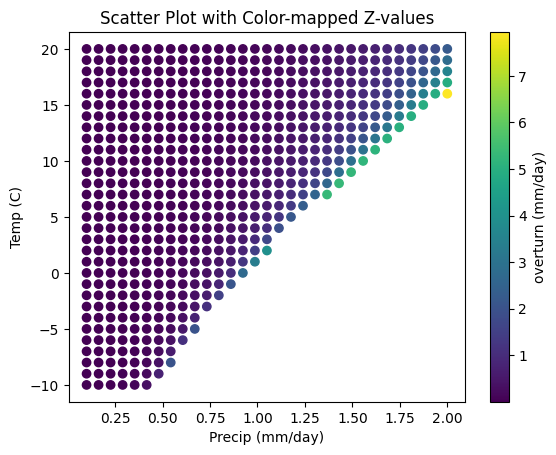

In [63]:
# Filter out data points where overturn is "overflow"
filtered_results = results[results["overturn"] != "Overflow"]

# Extract the data for the plot
precip = filtered_results["precip"]
temp = filtered_results["temp"]
overturn = filtered_results["overturn"]

plt.scatter(
    precip, temp, c=overturn, cmap="viridis"
)  # You can choose any colormap you prefer
plt.colorbar(label="overturn (mm/day)")  # Add color bar indicating the z-values
plt.xlabel("Precip (mm/day)")
plt.ylabel("Temp (C)")
plt.title("Scatter Plot with Color-mapped Z-values")
plt.show()

In [ ]:
# The Testing Plan
# steady state initial conditions
# calc new steady state al
# run until 50% of way to new steady state al (record time step)
# find the average elevation within the SGB polygon

# conditions:
# initial: (10, 0.8)
# warm, dry -> modern (16, 0.4)
# cold, dry -> (4, 0.4)
# warm, wet -> (16, 1.2)
# cold, wet -> (4, 1.2)

# tests:
# basin size; col_width(100, 200, 300, 400, 500)
# hypsometry; slope(0.005, 0.01, 0.05, 0.1, 0.25)
# conductivity; cond(10e-7, 20e-7, 30e-7, 40e-7, 50e-7)
# starting climate; t, p(16, 0.4), (4, 0.4), (16, 1.2), (4, 1.2)

In [ ]:
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.2,
    "water_slope": 0.05,
    "al_ab": 0.01,
    "elev": 1000,
    "col_width": 100,
    "cond": 15e-7,
    "t_step": 100,
    "precision": 100,
}

basin = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)
climate = np.zeros((100, 2))
climate[:, 0] = 1.4
climate[:, 1] = 12
steady_state_al(
    1.5,
    12,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    0.8,
    basin=basin,
)
# steady_state(climate, init['elev'], init['cond'], init['t_step'], init['precision'], basin=basin)

# with cond 15e-6 and colwidth 100, and t_step 10, steady took 12 min and 826000 iterations
# with cond 15e-6 and colwidth 100, and t_step 10, steady_state_al took 1.8 s and 1001 iterations (going to 50% al)
# with cond 15e-6 and colwidth 100, and t_step 10, steady_state_al took 3.8 s and 2901 iterations (going to 75% al)
# with cond 15e-6 and colwidth 100, and t_step 10, steady_state_al took 7.0 s and 5801 iterations (going to 90% al)
# with cond 15e-6 and colwidth 100, and t_step 10, steady_state_al took 12.5 s and 10601 iterations (going to 100% al)
# with cond 15e-7 and colwidth 100, and t_step 100, steady_state_al took over 15 min and 820000 iterations (going to 100% al)
# with cond 15e-7 and colwidth 100, and t_step 100, steady_state_al took 4.7 sec and 3901 iterations (going to 75% al)
# with cond 15e-7 and colwidth 100, and t_step 100, steady_state_al took over 2 min and 80000 iterations (going to 90% al)
# with cond 15e-7 and colwidth 100, and t_step 100, steady_state_al took over 2 min and 100000 iterations (going to 80% al)

Hypsometry Sensitivity

In [40]:
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.2,
    "water_slope": 0.001,
    "al_ab": 0.01,
    "elev": 500,
    "col_width": 100,
    "cond": 15e-7,
    "t_step": 100,
    "precision": 1,
}

init_climate = np.zeros((100, 2))
init_climate[:, 0] = 0.8
init_climate[:, 1] = 10

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954904721 d_table: 0.0005456811301769449


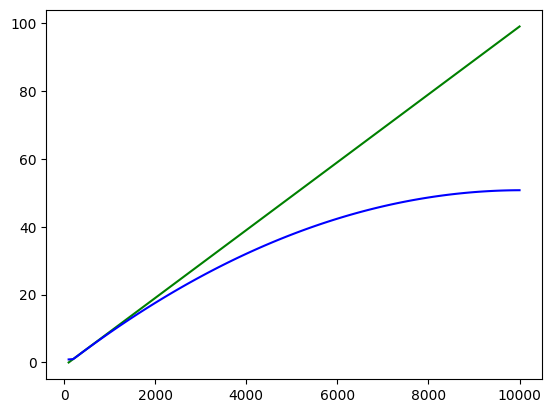

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0005589447537346359


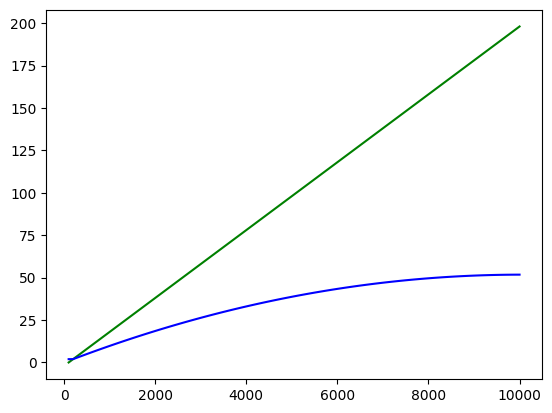

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.000573534905228712


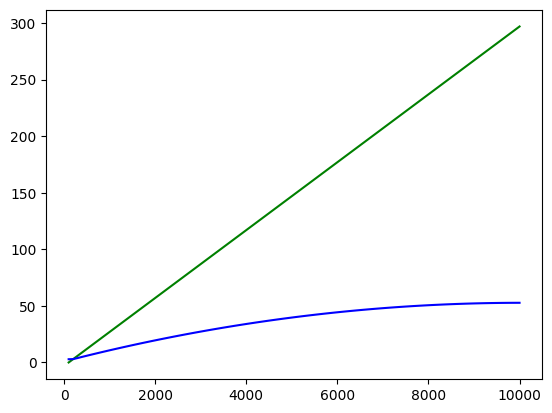

iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.001070089451635431 d_table: 0.0005884952545400779


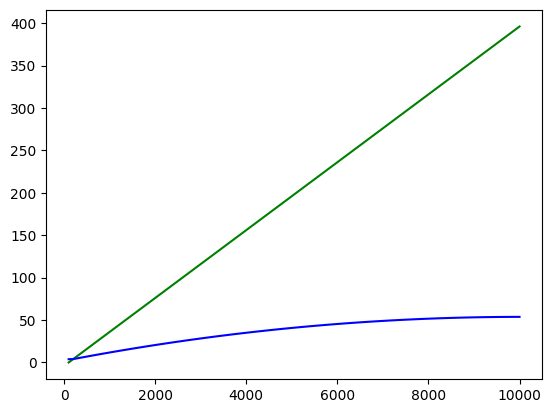

iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.0010700894516368863 d_table: 0.0006037629130304367


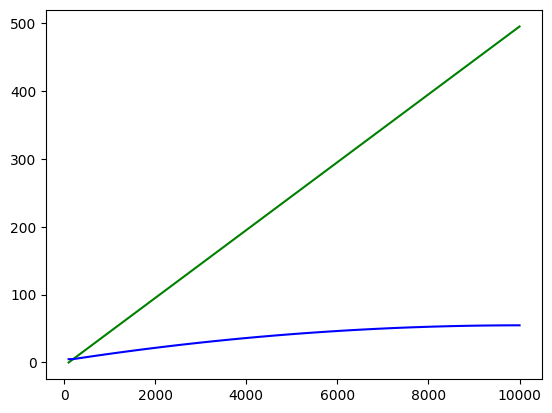

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.0006186829313463704


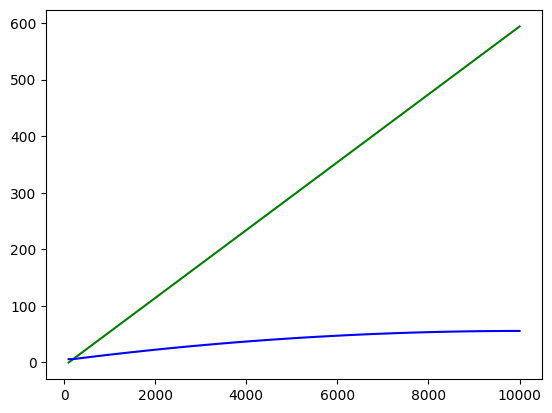

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006327531650427431


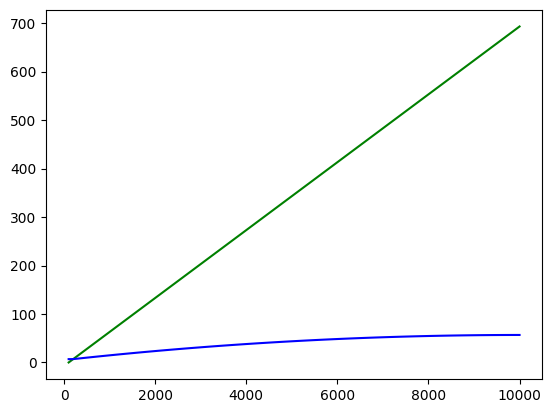

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006444748562302038


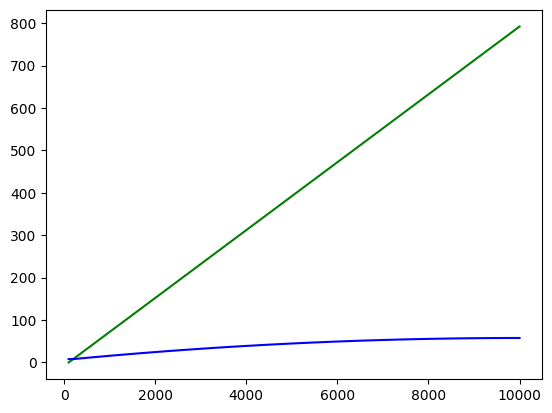

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006455638929026009


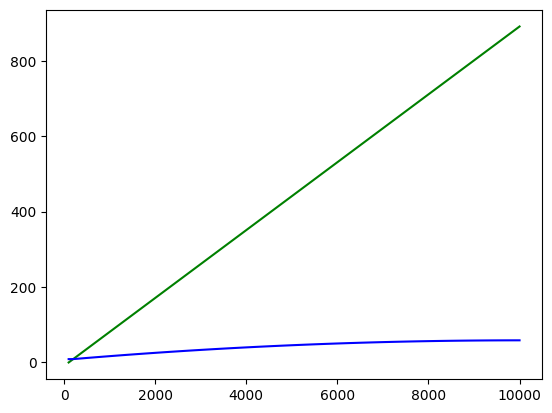

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954875618 d_table: 0.0006455638929026009


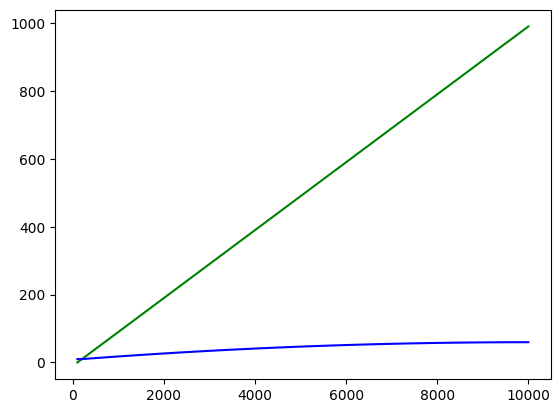

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954875618 d_table: 0.0006455638929026009


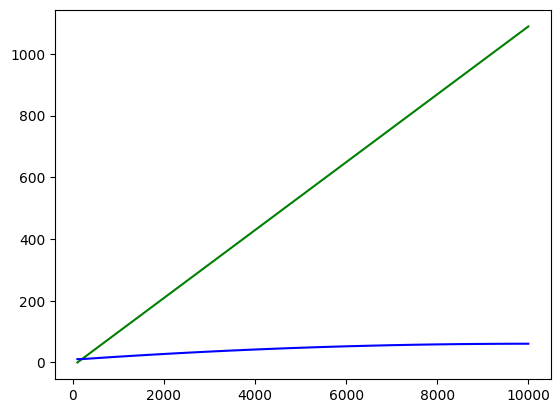

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.0006455638929026009


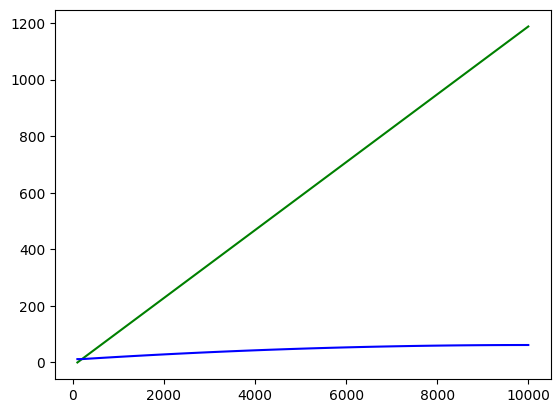

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954904721 d_table: 0.0006455638929026009


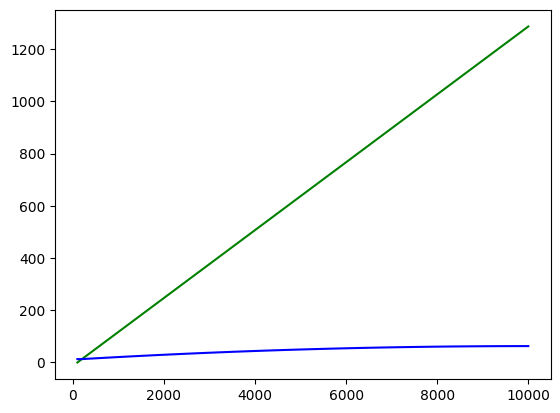

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.0006455638929026009


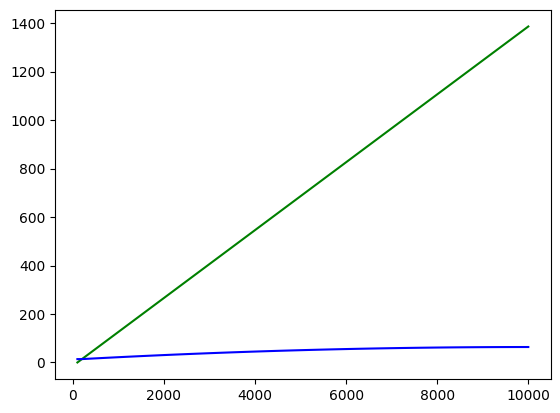

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006455638929026009


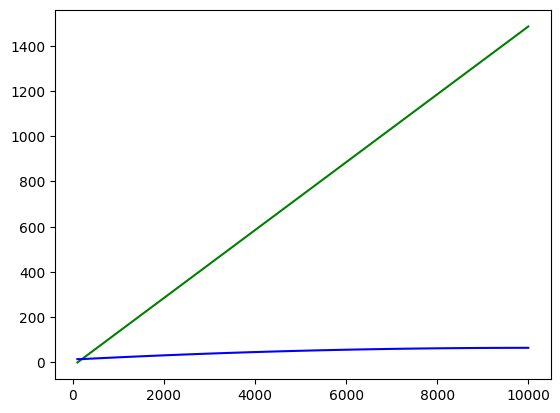

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006455638929026009


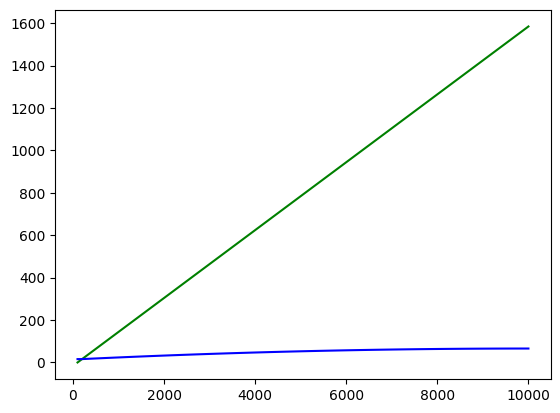

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.0006455638929026009


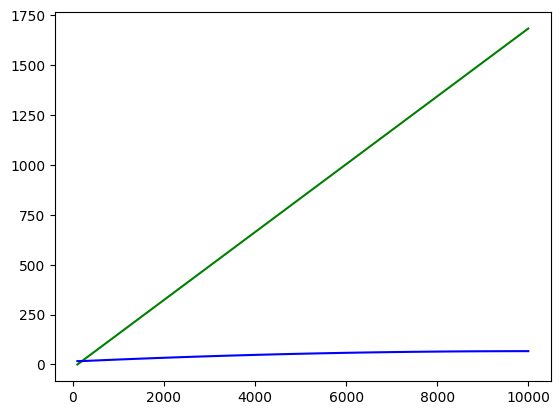

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006455638929026009


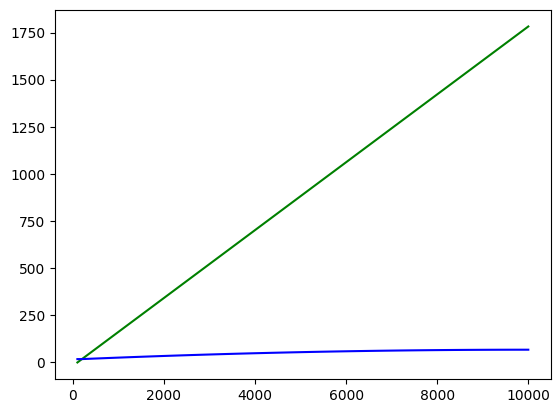

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.0006455638929026009


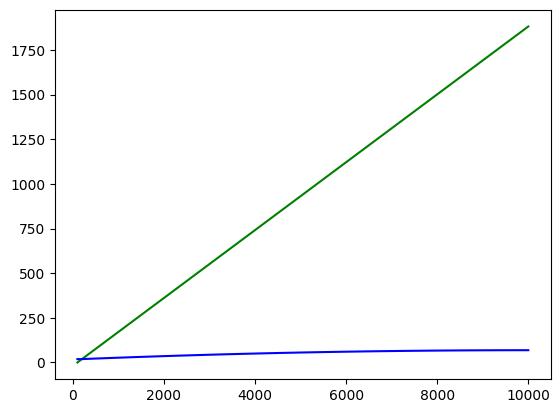

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006455638929026009


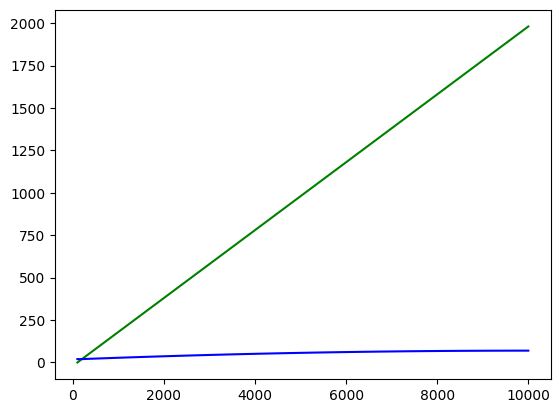

In [60]:
slope_basins = []
for i in range(20):
    slope = 0.01 + i * 0.01
    basin = col_two_d_basin(
        init["basin_width"],
        init["porosity"],
        slope,
        init["water_slope"],
        init["al_ab"],
        init["col_width"],
    )

    steady_state(
        init_climate,
        init["elev"],
        init["cond"],
        init["t_step"],
        init["precision"],
        basin=basin,
    )

    slope_basins.append(basin)

In [61]:
# test hypsometry
basins = slope_basins
slopes = [0.01 + i * 0.01 for i in range(20)]
p_tests = [0.4, 0.4, 0.4, 0.8, 0.8, 1.2, 1.2, 1.2]
t_tests = [16, 4, 10, 16, 4, 16, 4, 10]
results = pd.DataFrame(columns=["slope", "p", "t", "time"])
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            init["cond"],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        results.loc[len(results)] = [slopes[j], p_tests[i], t_tests[i], time]
        print("DONE", slopes[j], p_tests[i], t_tests[i], time)

1 0 0
iteration 0
1
DONE 0.01 0.4 16 (26, 1, 0, 0)
1 0 0
iteration 0
1
iteration 5000
1
DONE 0.01 0.4 4 (5322, 1, 0, 0)
1 0 0
iteration 0
1
DONE 0.01 0.4 10 (429, 1, 0, 0)
DONE 0.01 0.8 16 (0, 1, 1, 1)
1 4 2
iteration 0
1
DONE 0.01 0.8 4 (9, 1, 4, 2)
1 3 2
iteration 0
1
iteration 5000
1
DONE 0.01 1.2 16 (7312, 1, 3, 2)
1 92 46
iteration 0
1
DONE 0.01 1.2 4 (4396, 1, 92, 46)
1 9 5
iteration 0
1
DONE 0.01 1.2 10 (3291, 1, 9, 5)
1 0 0
iteration 0
1
DONE 0.02 0.4 16 (79, 1, 0, 0)
1 0 0
iteration 0
1
iteration 5000
1
DONE 0.02 0.4 4 (6373, 1, 0, 0)
1 0 0
iteration 0
1
DONE 0.02 0.4 10 (873, 1, 0, 0)
DONE 0.02 0.8 16 (0, 1, 1, 1)
1 4 2
iteration 0
1
DONE 0.02 0.8 4 (2, 1, 4, 2)
1 3 2
iteration 0
1
DONE 0.02 1.2 16 (3314, 1, 3, 2)
1 92 46
iteration 0
1
iteration 5000
28
iteration 10000
44
DONE 0.02 1.2 4 (10546, 1, 92, 46)
1 9 5
iteration 0
1
iteration 5000
3
iteration 10000
4
DONE 0.02 1.2 10 (10776, 1, 9, 5)
1 0 0
iteration 0
1
DONE 0.03 0.4 16 (161, 1, 0, 0)
1 0 0
iteration 0
1
iteration 5

In [64]:
results["actual_time"] = results["time"].apply(lambda x: x[0])

In [67]:
results

,slope,p,t,time,actual_time
0,0.01,0.4,16,"(26, 1, 0, 0)",26
1,0.01,0.4,4,"(5322, 1, 0, 0)",5322
2,0.01,0.4,10,"(429, 1, 0, 0)",429
3,0.01,0.8,16,"(0, 1, 1, 1)",0
4,0.01,0.8,4,"(9, 1, 4, 2)",9
...,...,...,...,...,...
155,0.20,0.8,16,"(0, 1, 1, 1)",0
156,0.20,0.8,4,"(16, 1, 4, 2)",16
157,0.20,1.2,16,"(3347, 1, 3, 2)",3347
158,0.20,1.2,4,"(111269, 1, 92, 46)",111269


In [66]:
results.to_csv("hypsometry_big.csv")

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954904721 d_table: 0.0005456811301769449


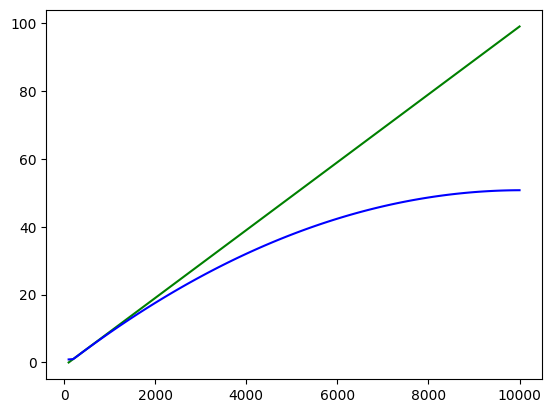

(35467,
 [0.01, 101136.5025941372, 50.7561690960769, 0.8, 10.0, 0.16053932471250784],
 [0.0, 0.0005353037954875618, 9.999837364205177e-05])

In [47]:
hyp_01 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    0.01,
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=hyp_01,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.0010700894516368863 d_table: 0.0006037629130304367


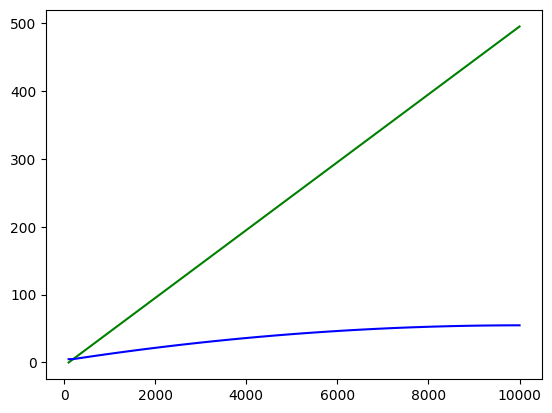

(36393,
 [0.01, 113415.95654299203, 54.75662165366038, 0.8, 10.0, 0.16053932471250784],
 [0.0, 0.0005353037954904721, 9.9996740814845e-05])

In [55]:
hyp_05 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    0.05,
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=hyp_05,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954875618 d_table: 0.0006455638929026009


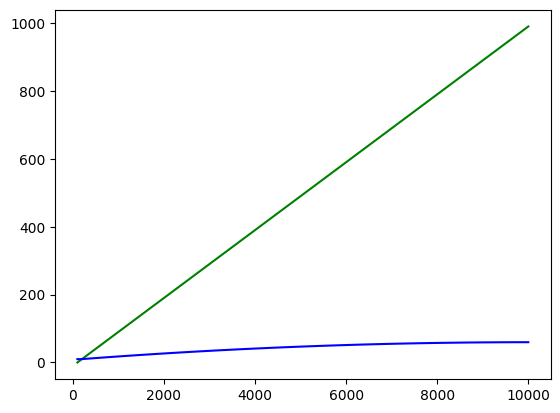

(37005,
 [0.01, 128765.25347377665, 59.75670393763977, 0.8, 10.0, 0.16053932471250784],
 [0.0, 0.0005353037954890169, 9.998777431974304e-05])

In [56]:
hyp_10 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    0.10,
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=hyp_10,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954919273 d_table: 0.0006455638929026009


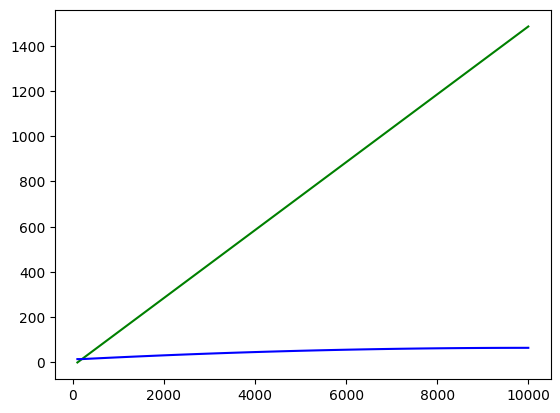

(37005,
 [0.01, 144115.2534737769, 64.75670393763987, 0.8, 10.0, 0.16053932471250784],
 [0.0, 0.0005353037954890169, 9.998777431974304e-05])

In [57]:
hyp_15 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    0.15,
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=hyp_15,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.0005353037954890169 d_table: 0.0006455638929026009


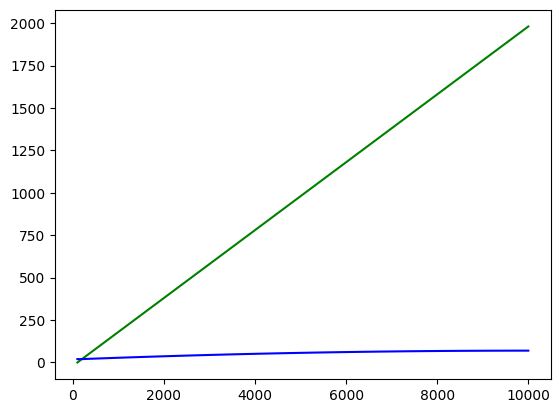

(37005,
 [0.01, 159465.25347377744, 69.75670393764005, 0.8, 10.0, 0.16053932471250784],
 [0.0, 0.0005353037954948376, 9.998777431974304e-05])

In [58]:
hyp_20 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    0.20,
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=hyp_20,
)

In [38]:
# test hypsometry
basins = [hyp_01, hyp_05, hyp_10, hyp_15, hyp_20]
slopes = [0.01, 0.05, 0.10, 0.15, 0.20]
p_tests = [0.4, 0.4, 1.2, 1.2]
t_tests = [16, 4, 16, 4]
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            init["cond"],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        print("DONE", slopes[j], p_tests[i], t_tests[i], time)

DONE 0.01 0.4 16 (0, 0, 0, 0)
DONE 0.01 0.4 4 (0, 0, 0, 0)
0 3 2
iteration 0
0
iteration 5000
1
iteration 10000
1
DONE 0.01 1.2 16 (11973, 0, 3, 2)
0 92 46
iteration 0
0
iteration 5000
37
DONE 0.01 1.2 4 (6485, 0, 92, 46)
1 0 0
iteration 0
1
DONE 0.05 0.4 16 (51, 1, 0, 0)
1 0 0
iteration 0
1
DONE 0.05 0.4 4 (221, 1, 0, 0)
1 3 2
iteration 0
1
iteration 5000
1
DONE 0.05 1.2 16 (8176, 1, 3, 2)
1 92 46
iteration 0
1
iteration 5000
11
iteration 10000
21
iteration 15000
29
iteration 20000
36
iteration 25000
41
DONE 0.05 1.2 4 (29217, 1, 92, 46)
1 0 0
iteration 0
1
DONE 0.1 0.4 16 (199, 1, 0, 0)
1 0 0
iteration 0
1
DONE 0.1 0.4 4 (949, 1, 0, 0)
1 3 2
iteration 0
1
iteration 5000
1
DONE 0.1 1.2 16 (8176, 1, 3, 2)
1 92 46
iteration 0
1
iteration 5000
7
iteration 10000
13
iteration 15000
18
iteration 20000
22
iteration 25000
27
iteration 30000
30
iteration 35000
34
iteration 40000
37
iteration 45000
40
iteration 50000
42
iteration 55000
45
DONE 0.1 1.2 4 (57162, 1, 92, 46)
1 0 0
iteration 0
1
DO

Conductivity Sensitivity

In [29]:
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.1,
    "water_slope": 0.001,
    "al_ab": 0.01,
    "elev": 500,
    "col_width": 100,
    "cond": 10e-6,
    "t_step": 15,
    "precision": 100,
}

init_climate = np.zeros((10, 2))
init_climate[:, 0] = 0.8
init_climate[:, 1] = 10

In [ ]:
cond_basins = []
cond_values = []
for i in range(20):
    cond = 5e-7 + i * 5e-7
    cond_values.append(cond)
    basin = col_two_d_basin(
        init["basin_width"],
        init["porosity"],
        init["ground_slope"],
        init["water_slope"],
        init["al_ab"],
        init["col_width"],
    )

    steady_state(
        init_climate,
        init["elev"],
        cond,
        init["t_step"],
        init["precision"],
        basin=basin,
    )

    cond_basins.append(basin)

# test conductivity
basins = cond_basins
conds = cond_values
p_tests = [0.4, 0.4, 0.4, 0.8, 0.8, 1.2, 1.2, 1.2]
t_tests = [16, 4, 10, 16, 4, 16, 4, 10]
results = pd.DataFrame(columns=["conductivity", "p", "t", "time"])
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            conds[j],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        results.loc[len(results)] = [conds[j], p_tests[i], t_tests[i], time]
        print("DONE", conds[j], p_tests[i], t_tests[i], time)

In [32]:
results.to_csv("conductivity_big.csv")

In [37]:
# test conductivity
basins = cond_basins
conds = cond_values
p_tests = [0.4, 0.4, 0.4, 0.8, 0.8, 1.2, 1.2, 1.2]
t_tests = [16, 4, 10, 16, 4, 16, 4, 10]
results = pd.DataFrame(columns=["conductivity", "p", "t", "time", "table_change"])
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        pre_table = basin_copy[99].w_height
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            conds[j],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        post_table = basin_copy[99].w_height
        results.loc[len(results)] = [
            conds[j],
            p_tests[i],
            t_tests[i],
            time,
            post_table - pre_table,
        ]
        print("DONE", conds[j], p_tests[i], t_tests[i], time, post_table - pre_table)

1 0 0
iteration 0
1
iteration 5000
1
DONE 5e-07 0.4 16 (6101, 1, 0, 0) -3.5995315960897187
1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
iteration 20000
1
iteration 25000
1
iteration 30000
1
iteration 35000
1
iteration 40000
1
iteration 45000
1
iteration 50000
1
iteration 55000
1
iteration 60000
1
iteration 65000
1
iteration 70000
1
iteration 75000
1
iteration 80000
1
iteration 85000
1
iteration 90000
1
iteration 95000
1
iteration 100000
1
iteration 105000
1
iteration 110000
1
iteration 115000
1
iteration 120000
1
iteration 125000
1
iteration 130000
1
iteration 135000
1
iteration 140000
1
iteration 145000
1
iteration 150000
1
DONE 5e-07 0.4 4 (154601, 1, 0, 0) -65.78277419105011
1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
iteration 20000
1
iteration 25000
1
iteration 30000
1
DONE 5e-07 0.4 10 (31101, 1, 0, 0) -17.5086349650133
DONE 5e-07 0.8 16 (0, 1, 1, 1) 0.0
1 4 2
iteration 0
2
DONE 5e-07 0.8 4 (1, 1, 4, 2) 0.000248395212253171

In [39]:
results.to_csv("conductivity_table_big.csv")

In [ ]:
# test conductivity
basins = cond_basins
conds = cond_values
p_tests = [0.4, 0.4, 0.4, 0.8, 0.8, 1.2, 1.2, 1.2]
t_tests = [16, 4, 10, 16, 4, 16, 4, 10]
results = pd.DataFrame(columns=["conductivity", "p", "t", "time"])
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            conds[j],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        results.loc[len(results)] = [conds[j], p_tests[i], t_tests[i], time]
        print("DONE", conds[j], p_tests[i], t_tests[i], time)

In [ ]:
cond_10e6 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    10e-6,
    init["t_step"],
    init["precision"],
    basin=cond_10e6,
)

In [ ]:
cond_75e7 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    75e-7,
    init["t_step"],
    init["precision"],
    basin=cond_75e7,
)

In [ ]:
cond_50e7 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    50e-7,
    init["t_step"],
    init["precision"],
    basin=cond_50e7,
)

In [ ]:
cond_25e7 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    25e-7,
    init["t_step"],
    init["precision"],
    basin=cond_25e7,
)

In [ ]:
cond_10e7 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    init["col_width"],
)

steady_state(
    init_climate,
    init["elev"],
    10e-7,
    init["t_step"],
    init["precision"],
    basin=cond_10e7,
)

In [ ]:
basins = [cond_10e6, cond_75e7, cond_50e7, cond_25e7, cond_10e7]
conds = [10e-6, 75e-7, 50e-7, 25e-7, 10e-7]
p_tests = [0.4, 0.4, 1.2, 1.2]
t_tests = [16, 4, 16, 4]
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            conds[j],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        print("DONE", conds[j], p_tests[i], t_tests[i], time)

Basin width Sensitivity

In [70]:
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.05,
    "water_slope": 0.001,
    "al_ab": 0.01,
    "elev": 500,
    "col_width": 100,
    "cond": 15e-7,
    "t_step": 100,
    "precision": 100,
}

init_climate = np.zeros((10, 2))
init_climate[:, 0] = 0.8
init_climate[:, 1] = 10

In [ ]:
wid_100 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    100,
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=wid_100,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.03854653652939014 d_table: 0.17753949771353916
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.012860244575387333 d_table: 0.0641588135362241
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 0.0032278850926377345 d_table: 0.021409119753386108
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 0.0016224918455118313 d_table: 0.007141638407645701
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 1.7098598388838583e-05 d_table: 0.002375169381195974
iteration 120000
al: 0.01 d_al: 0.0 d_vol: 1.7098598388838583e-05 d_table: 0.0007812666994055917
iteration 140000
al: 0.01 d_al: 0.0 d_vol: 1.7098598385928198e-05 d_table: 0.0002474617486569741


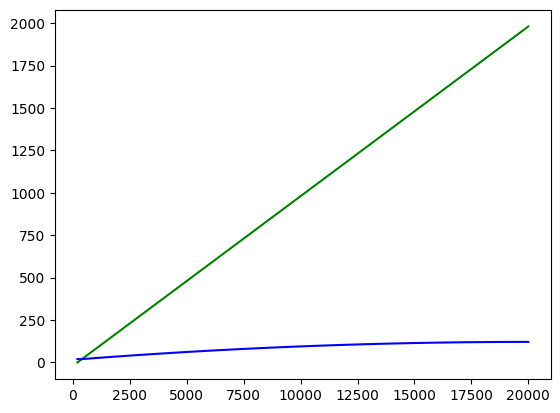

(153100,
 [0.01, 521927.026435318, 121.32732962978287, 0.8, 10.0, 0.16053932471250784],
 [0.0, 1.7098598388838583e-05, 9.968903351875724e-05])

In [32]:
wid_200 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    200,
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=wid_200,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.052995075753517445 d_table: 0.19794106429566227
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.02409799730509985 d_table: 0.13281211671676374
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 0.012860244575173905 d_table: 0.06412426660904202
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 0.006438671586647009 d_table: 0.03084130749778069
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 0.0032278850923913222 d_table: 0.014834362144256374
iteration 120000
al: 0.01 d_al: 0.0 d_vol: 0.0016224918452712397 d_table: 0.007134336455919765
iteration 140000
al: 0.01 d_al: 0.0 d_vol: 1.7098598143396278e-05 d_table: 0.0034286197325172907
iteration 160000
al: 0.01 d_al: 0.0 d_vol: 1.7098598143396278e-05 d_table: 0.0016445899225914218
iteration 180000
al: 0.01 d_al: 0.0 d_vol: 1.70985981511573e-05 d_table: 0.000785310192839006
iteration 200000
al: 0.01 d_al: 0.0 d_vol: 1.7098598135635258e-05 d_table: 0.0003710989327601055
iteration 220000
al: 0.01 d_al: 0.0 d_vol: 1.7098598143396

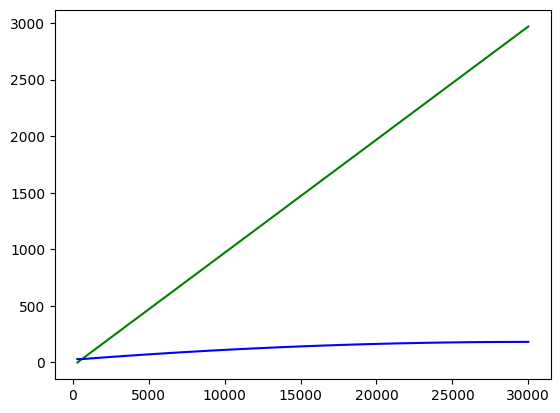

(233900,
 [0.01, 1174582.5854419137, 182.0118057210975, 0.8, 10.0, 0.16053932471250784],
 [0.0, 1.7098598135635258e-05, 9.967810308353364e-05])

In [33]:
wid_300 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    300,
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=wid_300,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.05299507575340685 d_table: 0.22231130486250095
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.03694114328201394 d_table: 0.17745362419213961
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 0.02088721081072581 d_table: 0.11092226133899885
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 0.012860244575090473 d_table: 0.0641052995375162
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 0.00643867158658104 d_table: 0.03701949094215706
iteration 120000
al: 0.01 d_al: 0.0 d_vol: 0.0032278850923350547 d_table: 0.021379861597182526
iteration 140000
al: 0.01 d_al: 0.0 d_vol: 0.0016224918452091516 d_table: 0.012347291614219102
iteration 160000
al: 0.01 d_al: 0.0 d_vol: 0.0016224918452091516 d_table: 0.007130398868582688
iteration 180000
al: 0.01 d_al: 0.0 d_vol: 1.709859807160683e-05 d_table: 0.004116438872870276
iteration 200000
al: 0.01 d_al: 0.0 d_vol: 1.7098598077427597e-05 d_table: 0.002375217836487309
iteration 220000
al: 0.01 d_al: 0.0 d_vol: 1.7098598083248364e-05 d_

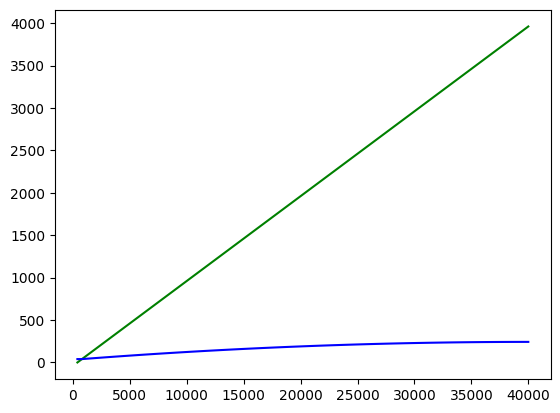

(312300,
 [0.01,
  2088285.3787885334,
  242.69311983676826,
  0.8,
  10.0,
  0.16053932471250784],
 [0.0, 1.709859807160683e-05, 9.975709960485801e-05])

In [34]:
wid_400 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    400,
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=wid_400,
)

iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.05299507575331722 d_table: 0.24663727049110662
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.05299507575323805 d_table: 0.18730114682284693
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 0.02891417704630643 d_table: 0.15220479417354227
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 0.019281817563604562 d_table: 0.09942106077312474
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 0.012860244575301185 d_table: 0.06409388602037325
iteration 120000
al: 0.01 d_al: 0.0 d_vol: 0.006438671586848795 d_table: 0.04130812546179641
iteration 140000
al: 0.01 d_al: 0.0 d_vol: 0.0048332783397473395 d_table: 0.026623544883022987
iteration 160000
al: 0.01 d_al: 0.0 d_vol: 0.003227885092627257 d_table: 0.01715964651629065
iteration 180000
al: 0.01 d_al: 0.0 d_vol: 0.0016224918454885483 d_table: 0.011059757606915355
iteration 200000
al: 0.01 d_al: 0.0 d_vol: 0.0016224918455071747 d_table: 0.007127877787922898
iteration 220000
al: 0.01 d_al: 0.0 d_vol: 1.7098598424345255e-05 d_tab

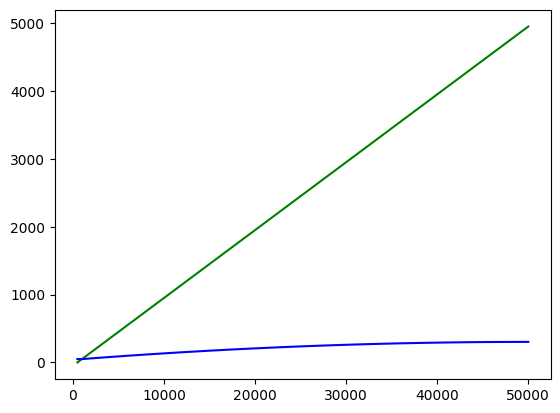

(388800,
 [0.01, 3263032.640321323, 303.37225864711155, 0.8, 10.0, 0.16053932471250784],
 [0.0, 1.7098598405718804e-05, 9.988268595861882e-05])

In [35]:
wid_500 = col_two_d_basin(
    init["basin_width"],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    500,
)

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=wid_500,
)

In [37]:
basins = [wid_100, wid_200, wid_300, wid_400, wid_500]
widths = [100, 200, 300, 400, 500]
p_tests = [0.4, 0.4, 1.2, 1.2]
t_tests = [16, 4, 16, 4]
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            init["cond"],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        print("DONE", widths[j], p_tests[i], t_tests[i], time)

1 0 0
iteration 0
1
DONE 100 0.4 16 (2201, 1, 0, 0)
1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
DONE 100 0.4 4 (12801, 1, 0, 0)
1 3 2
iteration 0
1
DONE 100 1.2 16 (3401, 1, 3, 2)
1 92 46
iteration 0
1
iteration 5000
9
iteration 10000
15
iteration 15000
20
iteration 20000
24
iteration 25000
28
iteration 30000
32
iteration 35000
35
iteration 40000
38
iteration 45000
41
iteration 50000
43
iteration 55000
45
DONE 100 1.2 4 (55301, 1, 92, 46)
1 0 0
iteration 0
1
DONE 200 0.4 16 (3001, 1, 0, 0)
1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
iteration 20000
1
iteration 25000
1
DONE 200 0.4 4 (26101, 1, 0, 0)
1 3 2
iteration 0
1
iteration 5000
1
DONE 200 1.2 16 (7101, 1, 3, 2)
1 92 46
iteration 0
1
iteration 5000
6
iteration 10000
9
iteration 15000
12
iteration 20000
15
iteration 25000
17
iteration 30000
20
iteration 35000
22
iteration 40000
24
iteration 45000
26
iteration 50000
28
iteration 55000
30
iteration 60000
32
iteration 65000
33
iteration 70000
35

In [40]:
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.1,
    "water_slope": 0.001,
    "al_ab": 0.01,
    "elev": 500,
    "col_width": 100,
    "cond": 10e-6,
    "t_step": 15,
    "precision": 100,
}

init_climate = np.zeros((10, 2))
init_climate[:, 0] = 0.8
init_climate[:, 1] = 10

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.564789760072017e-06 d_table: -0.00016404938669367652


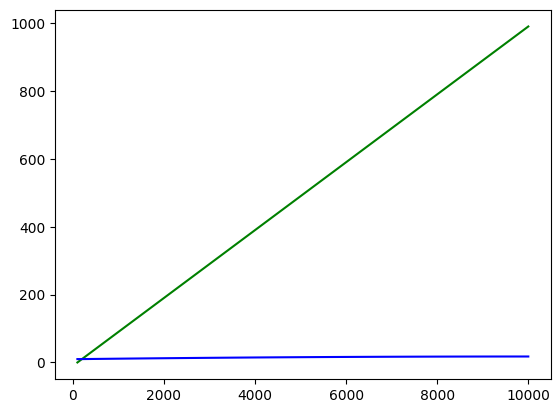

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647897588593576e-06 d_table: -0.00023843405261558814


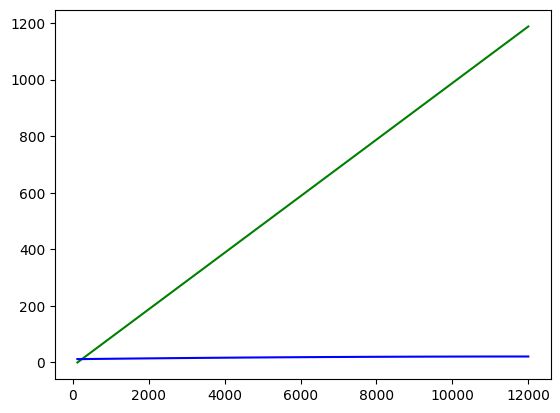

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647897605917284e-06 d_table: -0.0003106894893605272


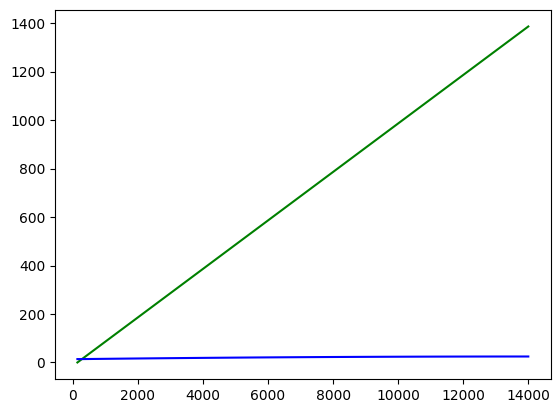

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647897582530277e-06 d_table: -0.0003788262605866066


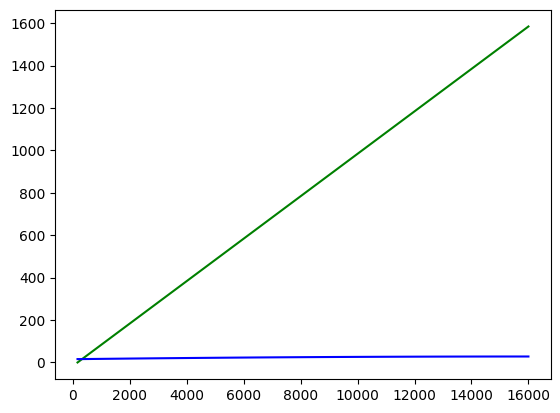

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647897580509176e-06 d_table: -0.00044261913588172774
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647897564340384e-06 d_table: -0.0001284376944994392


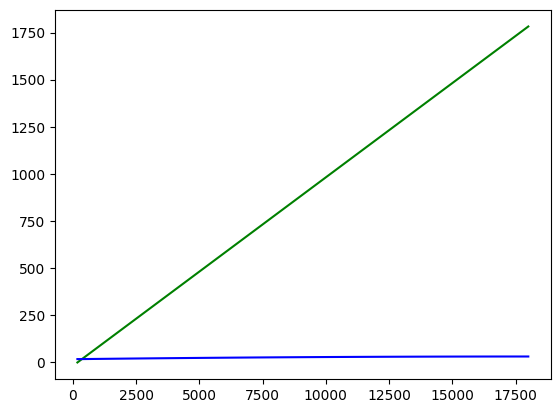

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647897098679096e-06 d_table: -0.0005038507564165684
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.564789714233484e-06 d_table: -0.00016472858851557248


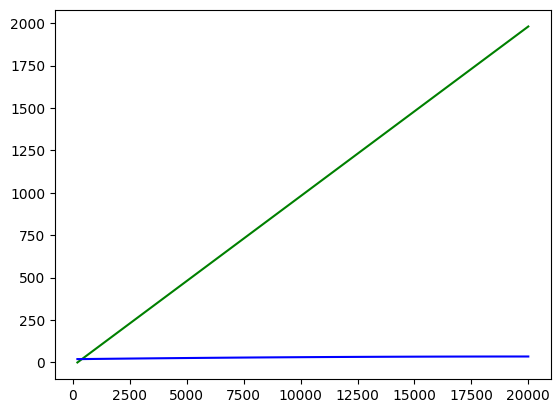

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419737237886 d_table: -0.0005649412119623776
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.564789694257673e-06 d_table: -0.00020167268871063015


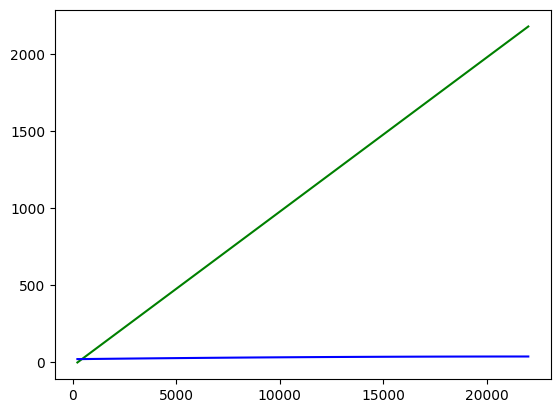

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.564789678823824e-06 d_table: -0.0006290382548428397
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896763985047e-06 d_table: -0.00023855834086816685


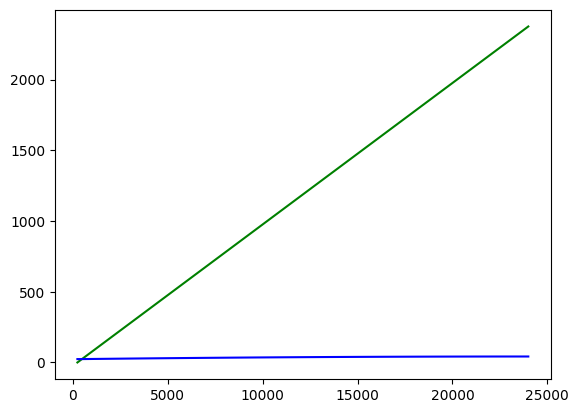

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419739629287 d_table: -0.0007000935148582244
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896691225467e-06 d_table: -0.0002749095051655104
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.564789671361303e-06 d_table: -0.00011720100720680193


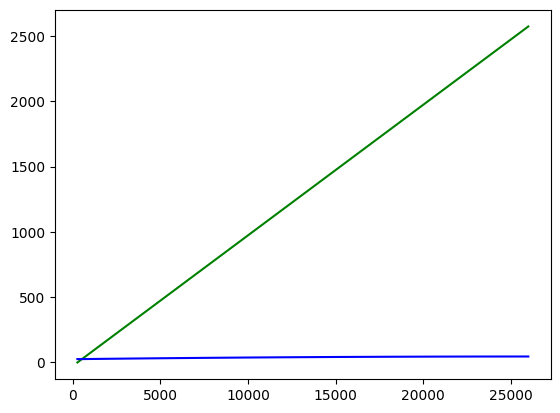

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647896608071667e-06 d_table: -0.0007821237116445445
iteration 40000
al: 0.01 d_al: 0.0 d_vol: -0.0002382441974041285 d_table: -0.00031037507142173126
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896608071667e-06 d_table: -0.00014085554806086975


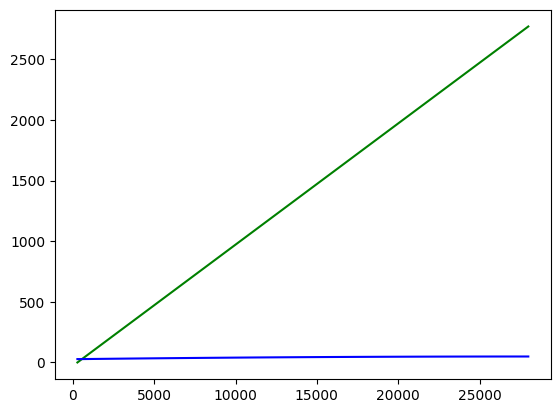

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419740703888 d_table: -0.0008790443610635634
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896633017808e-06 d_table: -0.00034482969395810414
iteration 60000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419740703888 d_table: -0.0001650717414634073


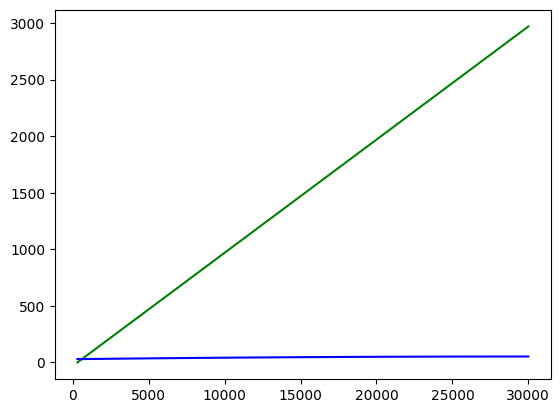

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.564789656389621e-06 d_table: -0.0009947955081415216
iteration 40000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419741322344 d_table: -0.0003781062359493603
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.564789656389621e-06 d_table: -0.00018953184692804825


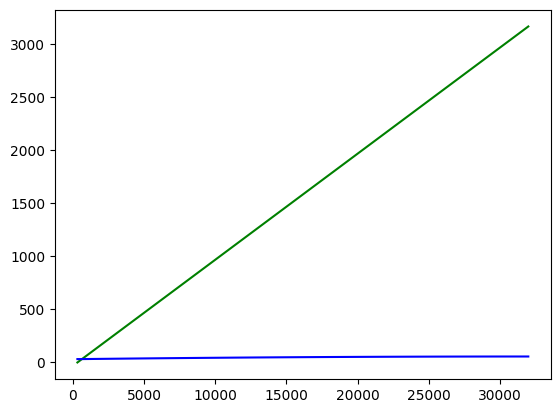

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419741354445 d_table: -0.0011320317853744655
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896554266266e-06 d_table: -0.000410456637688128
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896554266266e-06 d_table: -0.00021412301473588968
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.5647896520026467e-06 d_table: -0.00011167402367817658


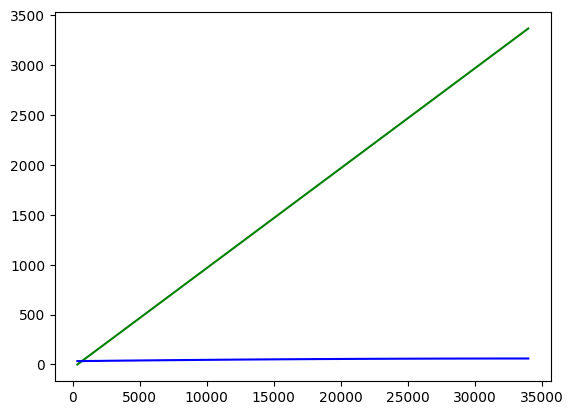

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.564789652953752e-06 d_table: -0.0012934485391369321
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.564789652953752e-06 d_table: -0.00044189086786161624
iteration 60000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419741868042 d_table: -0.00023860072929693388
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.5647896497199933e-06 d_table: -0.00012914215668757834


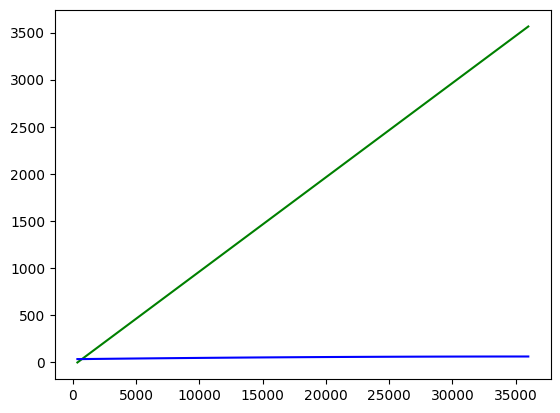

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419741408508 d_table: -0.0014809463252305477
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896476776194e-06 d_table: -0.0004726381859114781
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896507411804e-06 d_table: -0.0002628406189586485
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.5647896507411804e-06 d_table: -0.00014701373387993044


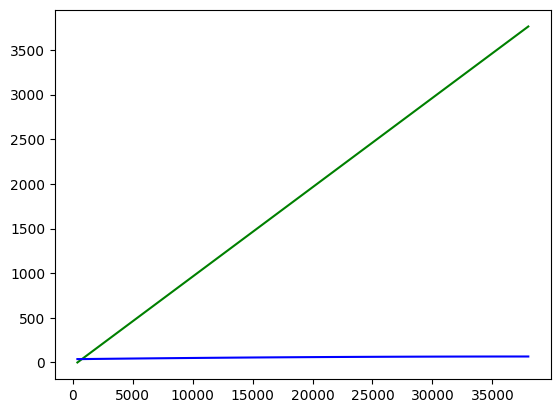

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419741868042 d_table: -0.0016959147126272
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896487498657e-06 d_table: -0.0005029298146723704
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896516602485e-06 d_table: -0.00028673697902092954
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.564789657481015e-06 d_table: -0.00016518192711600932


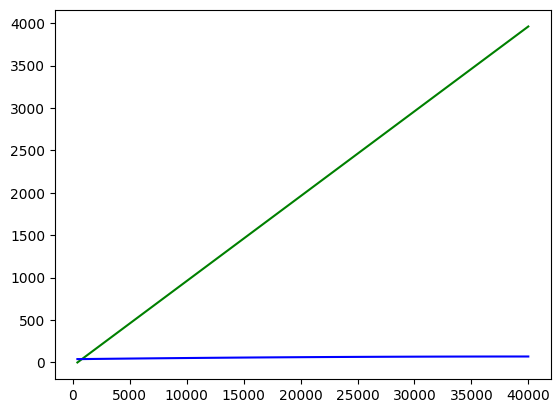

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647896580353733e-06 d_table: -0.0019395811686422348
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.56478965526358e-06 d_table: -0.0005330951985058618
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896524917866e-06 d_table: -0.0003101763571464744
iteration 80000
al: 0.01 d_al: 0.0 d_vol: -0.0002382441974172945 d_table: -0.00018347510638250242
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 2.5647896524917866e-06 d_table: -0.00010837547728215213


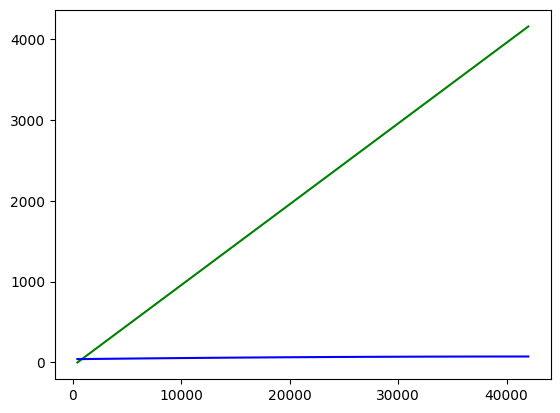

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647896479561247e-06 d_table: -0.002211130548957385
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.5647896506019274e-06 d_table: -0.0005636496812400082
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896506019274e-06 d_table: -0.0003332118382246563
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.5647896506019274e-06 d_table: -0.00020187994216769312
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 2.5647896532477305e-06 d_table: -0.00012220614087254944


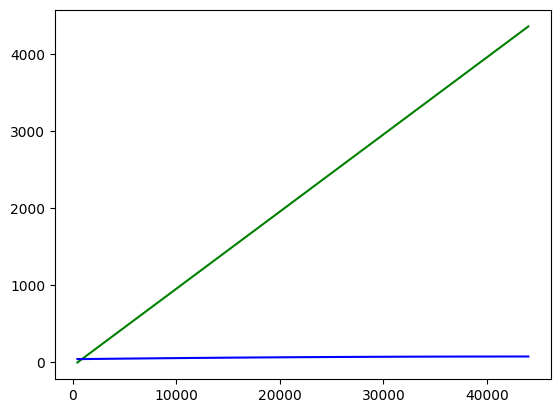

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647896539379395e-06 d_table: -0.0025112255992922883
iteration 40000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419740729196 d_table: -0.00059496472688636
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896539379395e-06 d_table: -0.0003557807756067177
iteration 80000
al: 0.01 d_al: 0.0 d_vol: -0.0002382441974123535 d_table: -0.0002202678089560095
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 2.5647896589994755e-06 d_table: -0.000136338374190359


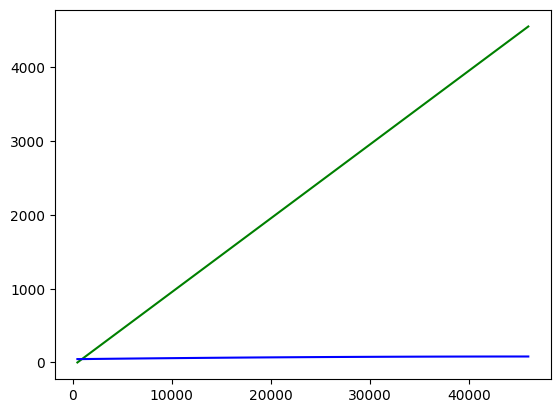

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.564789644869355e-06 d_table: -0.002839520873493484
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 2.564789644869355e-06 d_table: -0.0006274666909860116
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.5647896545706316e-06 d_table: -0.00037790208811827597
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.5647896545706316e-06 d_table: -0.00023858923833586232
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 2.5647896545706316e-06 d_table: -0.00015069773444054135


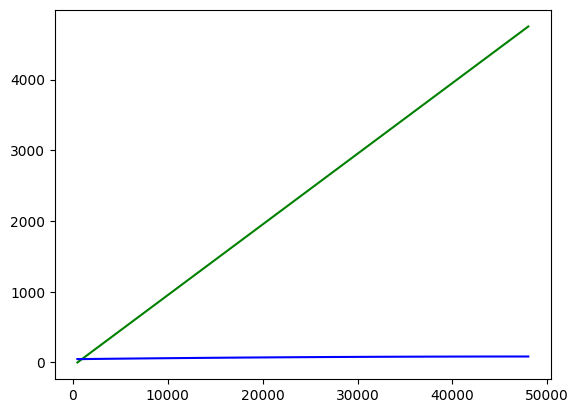

100
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 2.5647896621376276e-06 d_table: -0.003195284931322817
iteration 40000
al: 0.01 d_al: 0.0 d_vol: -0.00023824419741984456 d_table: -0.0006617142613549731
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 2.564789657481015e-06 d_table: -0.0003995285240847579
iteration 80000
al: 0.01 d_al: 0.0 d_vol: 2.5647896528244016e-06 d_table: -0.00025676682660957795
iteration 100000
al: 0.01 d_al: 0.0 d_vol: 2.5647896528244016e-06 d_table: -0.00016522862503620672
iteration 120000
al: 0.01 d_al: 0.0 d_vol: 2.5647896528244016e-06 d_table: -0.00010621494961071676


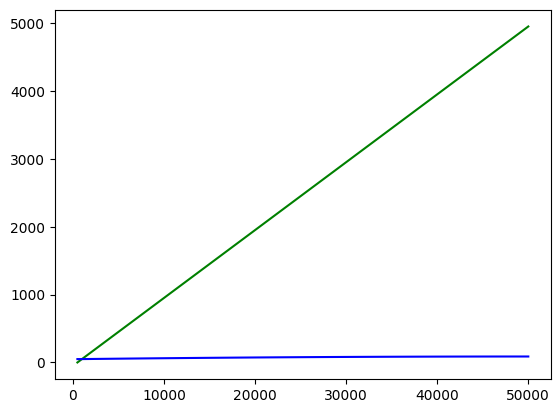

1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
DONE 100 0.4 16 (12701, 1, 0, 0) -8.587775761199023
1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
iteration 20000
1
iteration 25000
1
iteration 30000
1
iteration 35000
1
iteration 40000
1
iteration 45000
1
DONE 100 0.4 4 (47801, 1, 0, 0) -13.250997952178263
1 0 0
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
iteration 20000
1
DONE 100 0.4 10 (21901, 1, 0, 0) -10.873493115293599
DONE 100 0.8 16 (0, 1, 1, 1) 0.0
1 4 2
iteration 0
1
DONE 100 0.8 4 (101, 1, 4, 2) 0.02488558311934952
1 3 2
iteration 0
1
DONE 100 1.2 16 (3301, 1, 3, 2) 2.5945319860110274
1 92 46
iteration 0
1
iteration 5000
3
iteration 10000
4
iteration 15000
5
iteration 20000
6
iteration 25000
7
iteration 30000
8
iteration 35000
9
iteration 40000
10
iteration 45000
11
iteration 50000
12
iteration 55000
13
iteration 60000
14
iteration 65000
15
iteration 70000
15
iteration 75000
16
iteration 80000
17
iteration 85000
18
itera

In [46]:
width_basins = []
width_values = []
for i in range(21):
    width = 100 + i * 20
    width_values.append(width)
    basin = col_two_d_basin(
        init["basin_width"],
        init["porosity"],
        init["ground_slope"],
        init["water_slope"],
        init["al_ab"],
        width,
    )

    steady_state(
        init_climate,
        init["elev"],
        init["cond"],
        init["t_step"],
        init["precision"],
        basin=basin,
    )

    width_basins.append(basin)

# test conductivity
basins = width_basins
widths = width_values
p_tests = [0.4, 0.4, 0.4, 0.8, 0.8, 1.2, 1.2, 1.2]
t_tests = [16, 4, 10, 16, 4, 16, 4, 10]
results = pd.DataFrame(columns=["width", "p", "t", "time", "table_change"])
for j in range(len(basins)):
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basins[j])
        pre_table = basin_copy[99].w_height
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            init["cond"],
            init["t_step"],
            init["precision"],
            0.5,
            basin=basin_copy,
        )
        post_table = basin_copy[99].w_height
        results.loc[len(results)] = [
            widths[j],
            p_tests[i],
            t_tests[i],
            time,
            post_table - pre_table,
        ]
        print("DONE", widths[j], p_tests[i], t_tests[i], time, post_table - pre_table)

In [47]:
results.to_csv("width_table_big.csv")

Starting Climate Sensitivity

iteration 20000
al: 0.01 d_al: 0.01 d_vol: 0.0028319760425809365 d_table: 0.010197655399096561
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.0006241273200153955 d_table: 0.0012225867447668293
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 3.1570728127553596e-05 d_table: 0.00012181544585132542


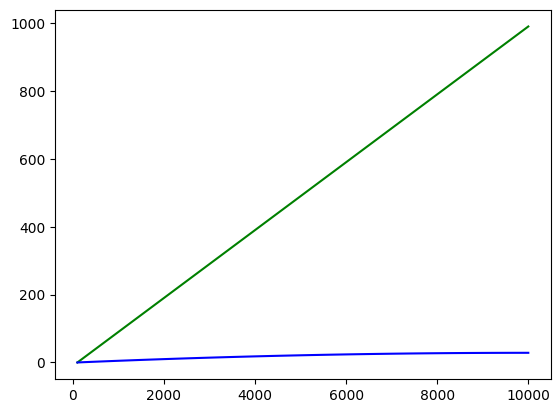

DONE 0.6 7 1
iteration 20000
al: 0.0 d_al: 0.0 d_vol: 0.001033456786126044 d_table: 0.005393890893923725
iteration 40000
al: 0.01 d_al: 0.01 d_vol: 0.0012088142090360633 d_table: 0.0006425694531451143


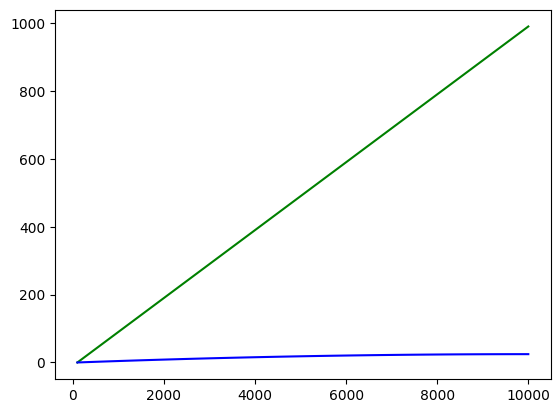

DONE 0.6 10 1
iteration 20000
al: 0.01 d_al: -0.01 d_vol: -0.00019319129357245403 d_table: 0.0013617100634455426
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.0004357638273409975 d_table: 0.00014340423932068802


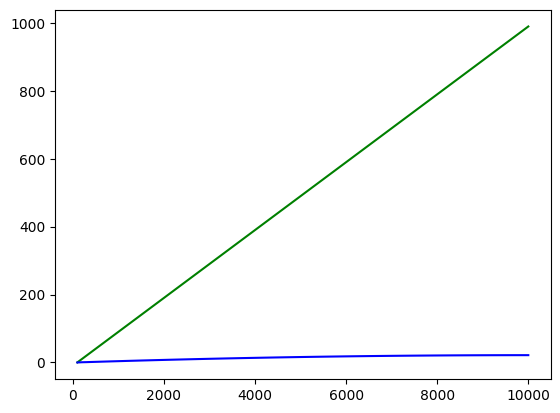

DONE 0.6 13 0
iteration 20000
al: 0.02 d_al: 0.0 d_vol: 0.03353516959669069 d_table: 0.08223744026369673
iteration 40000
al: 0.02 d_al: 0.0 d_vol: 0.0041309137950273 d_table: 0.020581061599884265
iteration 60000
al: 0.02 d_al: 0.0 d_vol: 0.001330508480584831 d_table: 0.0021861258044140186
iteration 80000
al: 0.02 d_al: 0.0 d_vol: 0.0013305084805790102 d_table: 0.00023232197841593916


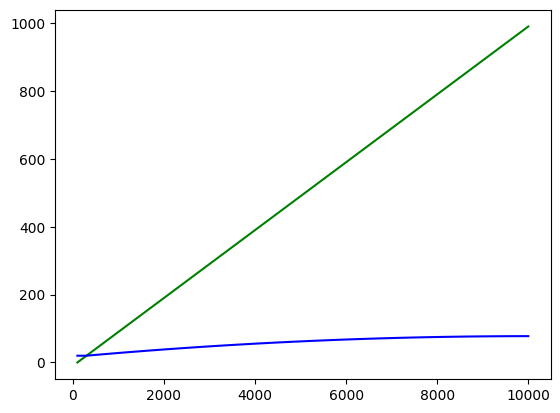

DONE 0.8 7 2
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.012860244575390242 d_table: 0.06426298024899779
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 1.709859838447301e-05 d_table: 0.007160289173711476
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 1.7098598391748964e-05 d_table: 0.0007694437100340679


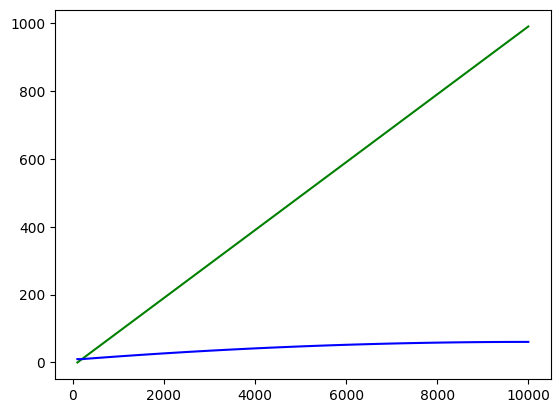

DONE 0.8 10 1
iteration 20000
al: 0.01 d_al: 0.0 d_vol: 0.015131294655379315 d_table: 0.05040252886004737
iteration 40000
al: 0.01 d_al: 0.0 d_vol: 0.004224778636303381 d_table: 0.02514644966147017
iteration 60000
al: 0.01 d_al: 0.0 d_vol: 0.0005892732966109179 d_table: 0.0027801198103531988
iteration 80000
al: 0.01 d_al: 0.0 d_vol: -0.0012284793732353137 d_table: 0.000308604479776875


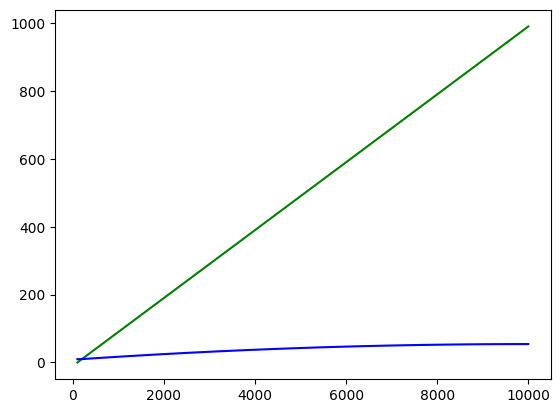

DONE 0.8 13 1
iteration 20000
al: 0.03 d_al: 0.0 d_vol: 0.03802594611204113 d_table: 0.19870298209502835
iteration 40000
al: 0.04 d_al: 0.0 d_vol: 0.01243612577993772 d_table: 0.0631450952896273
iteration 60000
al: 0.04 d_al: 0.0 d_vol: 0.0012345045221445617 d_table: 0.00610696616914197
iteration 80000
al: 0.04 d_al: 0.0 d_vol: -0.00016569813507958316 d_table: 0.0005903239674864835


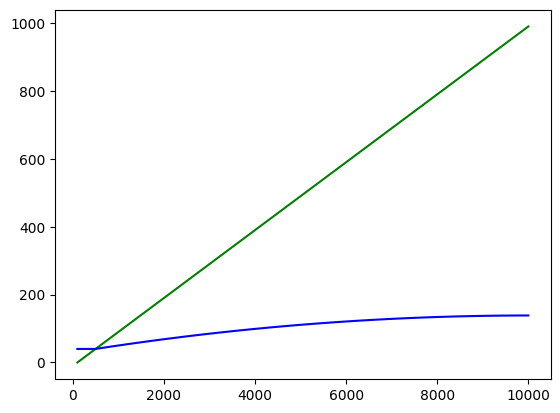

DONE 1 7 4
iteration 20000
al: 0.02 d_al: 0.0 d_vol: 0.024581999777784223 d_table: 0.13460178592310967
iteration 40000
al: 0.02 d_al: 0.0 d_vol: 0.0021064943180419504 d_table: 0.01430900652236744
iteration 60000
al: 0.02 d_al: 0.0 d_vol: -0.0011042921762098557 d_table: 0.0015217738107224932
iteration 80000
al: 0.02 d_al: 0.0 d_vol: 0.0005011010709189577 d_table: 0.00016344674830293116


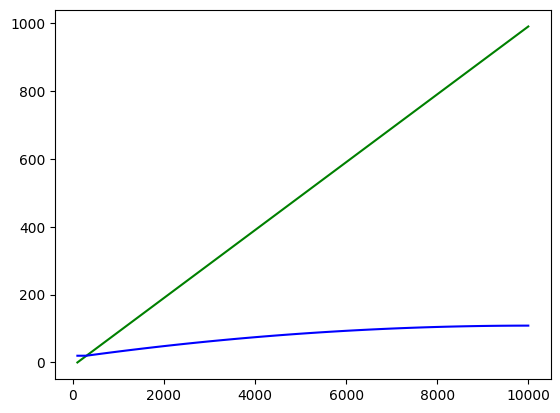

DONE 1 10 2
iteration 20000
al: 0.02 d_al: 0.0 d_vol: 0.04276393017914379 d_table: 0.1308784231723621
iteration 40000
al: 0.02 d_al: 0.0 d_vol: 0.004591124112336547 d_table: 0.020235740831154203
iteration 60000
al: 0.02 d_al: 0.0 d_vol: -0.0008621338972152443 d_table: 0.0021494237960695273
iteration 80000
al: 0.02 d_al: 0.0 d_vol: -0.0008621338972065132 d_table: 0.00022838629716659398


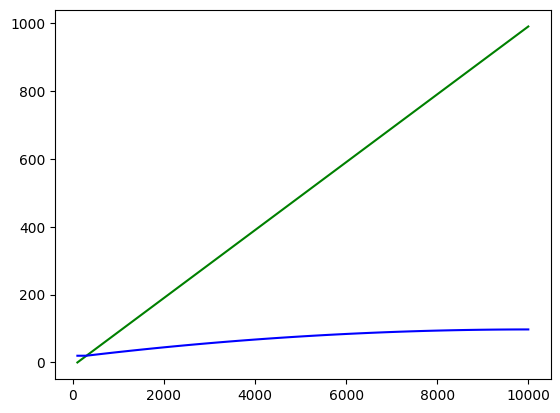

DONE 1 13 2


In [44]:
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.1,
    "water_slope": 0.001,
    "al_ab": 0.01,
    "elev": 500,
    "col_width": 100,
    "cond": 15e-7,
    "t_step": 100,
    "precision": 100,
}

basins_pt = []
overall_p = []
overall_t = []
p_variation = [0.6, 0.8, 1]
t_variation = [7, 10, 13]
for p in p_variation:
    for t in t_variation:
        basin = col_two_d_basin(
            init["basin_width"],
            init["porosity"],
            init["ground_slope"],
            init["water_slope"],
            init["al_ab"],
            init["col_width"],
        )
        overall_p.append(p)
        overall_t.append(t)
        climate = np.zeros((10, 2))
        climate[:, 0] = p
        climate[:, 1] = t
        steady_state(
            climate,
            init["elev"],
            init["cond"],
            init["t_step"],
            init["precision"],
            basin=basin,
        )
        basins_pt.append(basin)
        al = col_calc_al(basin)
        print("DONE", p, t, al)

In [57]:
p_change = [-0.2, 0, 0.2]
t_change = [-3, 0, 3]

for i in range(len(basins_pt)):
    for j in p_change:
        for t in t_change:
            basin_copy = copy_basin(basins_pt[i])
            time = steady_state_al(
                overall_p[i] + j,
                overall_t[i] + t,
                init["elev"],
                init["cond"],
                init["t_step"],
                init["precision"],
                0.5,
                basin=basin_copy,
            )
            print(
                "DONE",
                f"P: {overall_p[i]} p_change: {j}",
                f"T: {overall_t[i]} t_change: {t}",
                time,
            )

1 0 0
iteration 0
1
DONE P: 0.6 p_change: -0.2 T: 7 t_change: -3 (301, 1, 0, 0)
1 0 0
iteration 0
0
DONE P: 0.6 p_change: -0.2 T: 7 t_change: 0 (1, 1, 0, 0)
1 0 0
iteration 0
0
DONE P: 0.6 p_change: -0.2 T: 7 t_change: 3 (1, 1, 0, 0)
DONE P: 0.6 p_change: 0 T: 7 t_change: -3 (0, 1, 1, 1)
DONE P: 0.6 p_change: 0 T: 7 t_change: 0 (0, 1, 1, 1)
DONE P: 0.6 p_change: 0 T: 7 t_change: 3 (0, 1, 1, 1)
1 4 2
iteration 0
1
iteration 5000
1
DONE P: 0.6 p_change: 0.2 T: 7 t_change: -3 (5701, 1, 4, 2)
1 3 2
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
DONE P: 0.6 p_change: 0.2 T: 7 t_change: 0 (16101, 1, 3, 2)
1 2 2
iteration 0
1
iteration 5000
1
iteration 10000
1
iteration 15000
1
iteration 20000
1
iteration 25000
1
iteration 30000
1
iteration 35000
1
iteration 40000
1
iteration 45000
1
iteration 50000
1
iteration 55000
1
iteration 60000
1
iteration 65000
1
iteration 70000
1
iteration 75000
1
iteration 80000
1
iteration 85000
1
iteration 90000
1
iteration 95000
1
iteration 10

KeyboardInterrupt: 

In [53]:
overall_t

[7, 10, 13, 7, 10, 13, 7, 10, 13]

In [51]:
steady_al(1.2, 16, 100, 500, 1)

3

In [ ]:
wid_500 = col_two_d_basin(
    init['basin_width'],
    init["porosity"],
    init["ground_slope"],
    init["water_slope"],
    init["al_ab"],
    500,
)

climate = np.zeros((10, 2))
climate[:, 0] = 0.8
climate[]

steady_state(
    init_climate,
    init["elev"],
    init["cond"],
    init["t_step"],
    init["precision"],
    basin=wid_500,
)

Playground

In [ ]:
# test hypsometry
init = {
    "basin_width": 100,
    "porosity": 0.3,
    "ground_slope": 0.2,
    "water_slope": 0.001,
    "al_ab": 0.01,
    "elev": 500,
    "col_width": 100,
    "cond": 30e-7,
    "t_step": 100,
    "precision": 100,
}

result_columns = ["slope", "p", "t", "time"]
results = pd.DataFrame(columns=result_columns)

slopes = [0.01, 0.05, 0.1, 0.15, 0.20]
p_tests = [0.4, 0.4, 1.6, 1.6]
t_tests = [16, 4, 16, 4]

init_climate = np.zeros((100, 2))
init_climate[:, 0] = 0.8
init_climate[:, 1] = 10

for s in slopes:
    basin = col_two_d_basin(
        init["basin_width"],
        init["porosity"],
        s,
        init["water_slope"],
        init["al_ab"],
        init["col_width"],
    )
    steady_state(
        init_climate,
        init["elev"],
        init["cond"],
        init["t_step"],
        init["precision"],
        basin=basin,
    )
    print("steady")
    for i in range(len(p_tests)):
        basin_copy = copy_basin(basin)
        col_view_sys(basin_copy)
        time = steady_state_al(
            p_tests[i],
            t_tests[i],
            init["elev"],
            init["cond"],
            init["t_step"],
            init["precision"],
            0.667,
            basin=basin_copy,
        )
        print(results)
        print(s, p_tests[i], t_tests[i], time)
        results.loc[len(results)] = [s, p_tests[i], t_tests[i], time[0]]


# basin = col_two_d_basin(init['basin_width'], init['porosity'], init['ground_slope'], init['water_slope'], init['al_ab'], init['col_width'])
# steady_state_al(, init['elev'], init['cond'], init['t_step'], init['precision'], .5, basin=basin)

In [ ]:
columns = ["width", "time"]
results = pd.DataFrame(columns=columns)

results.loc[len(results)] = [100, 100]
results.loc[len(results)] = [200, 200]

In [67]:
steady_al(0.4, 4, 100, 500, 1)

0